In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et
import re
from collections import Counter

pd.options.display.max_columns = 999

# Florida

## VEST Documentation

Election results from the Florida Department of State (https://dos.myflorida.com/elections/data-statistics/elections-data/precinct-level-election-results/)

Precinct results from several sources.  
- Alachua, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State.  
- Broward, Gadsden, Gilchrist, Manatee, Nassau, Santa Rosa, St. Johns, St. Lucie, and Union are from the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  
- Baker, Charlotte, Franklin, Glades, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Monroe, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program.  
- Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.
- Hamilton was drawn based on a geocoded voter registration file.  
- Edits were made to Brevard, Charlotte, Escambia, Franklin, Indian River, Jefferson, Lafayette, Lake, and Lee, Miami-Dade, and St. Johns based on the voter registration file.  

Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREODEL - Roque "Rocky" De La Fuente (Reform Party)  
G20PRESLAR - Gloria La Riva (Party for Socialism and Liberation)  
G20PREGHAW - Howie Hawkin (Green Party)  
G20PRECBLA - Don Blankenship (Constitution Party)  
G20PREOWRI - Write-in Votes  

## Load VEST File

In [2]:
vest_fl_20 = gp.read_file("./raw-from-source/VEST/mod_vest_clean/mod_vest_clean.shp")

In [3]:
vest_fl_20.columns

Index(['pct_std', 'county', 'precinct', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREODEL', 'G20PRESLAR', 'G20PREGHAW', 'G20PRECBLA',
       'G20PREOWRI', 'COUNTYFP', 'geometry'],
      dtype='object')

In [4]:
data_columns = [col for col in vest_fl_20.columns if "G20" in col]

## Load the Main Primary Election Results

Fields and codes data https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdfF

In [5]:
#This Data is from the FL department of state, and can only be downloaded county by county
all_files = os.listdir("./raw-from-source/Election_Results/main_primary/")

#Check that all files have the same number of columns
for i in all_files:
    if i !=".DS_Store" and "recount" not in i:
        ref = "./raw-from-source/Election_Results/main_primary/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        if (file_prev.shape[1]!=19):
            print(i)
        #print(file_prev.shape)
    
#All the files have 19 columns, so they should be good to combine

li = []
for i in all_files:
    if i !=".DS_Store" and "recount" not in i and i != "PAL_PctResults20200818.txt":
        ref = "./raw-from-source/Election_Results/main_primary/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        li.append(file_prev)
prim_frame = pd.concat(li, axis=0, ignore_index=True)
print(prim_frame.shape)

(279939, 19)


In [6]:
print(sum(prim_frame[(prim_frame[0]=="SEM") & (prim_frame[11] == "State Representative") & (prim_frame[14].str.contains("Pla"))][18]))
print(sum(prim_frame[(prim_frame[0]=="SEM") & (prim_frame[11] == "State Representative") & (prim_frame[14].str.contains("Man"))][18]))
print(sum(prim_frame[(prim_frame[0]=="SEM") & (prim_frame[11] == "State Representative") & (prim_frame[14].str.contains("Bak"))][18]))



11611
6426
6532


PSL029RPLA
- SEM: 11611 votes | 11612 votes official results

PSL028DMAN
- SEM: 6426 votes | 6425 votes official results

PSL028DBAK
- SEM: 6532 votes | 6533 votes official results

In [7]:
frame = prim_frame.copy(deep = True)

https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdf

In [8]:
col_rename_dict = {0: 'County Code (Three-character abbreviation)',
 1: 'County Name',
 2: 'Election Number',
 3: 'Election Date',
 4: 'Election Name',
 5: 'Unique Precinct Identifier',
 6: 'Precinct Polling Location',
 7: 'Total Registered Voters',
 8: 'Total Registered Republicans',
 9: 'Total Registered Democrats',
 10: 'Total Registered All Other Parties',
 11: 'Contest Name',
 12: 'District',
 13: 'Contest Code (Florida’s 6 digit contest codes)',
 14: 'Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes',
 15: 'Candidate Party (abbreviation)',
 16: 'Candidate Florida Voter Registration System ID Number',
 17: 'DOE Assigned Candidate Number or Retention/Issue Number',
 18: 'Vote Total'}

In [9]:
frame.rename(columns = col_rename_dict, inplace = True)

In [10]:
frame["Contest Name"].unique()

array(['State Senator', 'Tax Collector', 'Superintendent of Schools',
       'County Commissioner', 'State Attorney',
       'Clerk of the Circuit Court and Comptroller', 'Sheriff',
       'Property Appraiser', 'School Board', 'Circuit Judge',
       'County Court Judge', 'Representative in Congress',
       'State Representative', 'Public Defender',
       'Port of Palm Beach District', 'Supervisor of Elections',
       'Greater Boca Raton Beach and Park District',
       'Jupiter Inlet District', 'Clerk of the Circuit Court',
       'Lake Region Lakes Management District',
       'Hendry County Hospital Authority',
       'Charlotte County Airport Authority', 'County Council Chair',
       'County Council', 'Mayor', 'Emerald Coast Utilities Authority',
       'Sarasota County Charter Review Board',
       'Sarasota County Public Hospital Board',
       'Lake County Water Authority',
       'North Lake County Hospital District',
       'Ocean Highway and Port Authority', 'City Council

In [11]:
races_list = ['State Representative']

In [12]:
#Filter to the presidential results
frame =frame[frame['Contest Name'].isin(races_list)]

#Filter out the OverVotes and UnderVotes
filtered_frame = frame[~frame['Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes'].isin(['OverVotes', 'UnderVotes'])]

#Clean up the precinct column
filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)

#Deal with Dade County
filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-character abbreviation)']=="DAD" else row['Unique Precinct Identifier'], axis=1)

#Add in exception for Sarasota - use the precinct polling location
filtered_frame["mod_col"] = np.where(filtered_frame["County Name"]=="Sarasota", filtered_frame["Precinct Polling Location"], filtered_frame["mod_col"])

#Make the precinct column at least 4 digits
filtered_frame["mod_col"]=filtered_frame["mod_col"].astype(str)
filtered_frame["modified_pre"]=filtered_frame["mod_col"].str.zfill(4)

#Make a column with the 3 letter county code and the precincts
filtered_frame["pct_std"]=filtered_frame['County Code (Three-character abbreviation)']+filtered_frame["modified_pre"]

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/3274452090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/3274452090.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-c

In [13]:
name_update_dict = {}
for i in list(filtered_frame["pct_std"]):
    if (i[0:3] == i[3:6]):
        name_update_dict[i] = i[3:]

In [14]:
filtered_frame["pct_std"]=filtered_frame["pct_std"].map(name_update_dict).fillna(filtered_frame["pct_std"])

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/643207484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pct_std"]=filtered_frame["pct_std"].map(name_update_dict).fillna(filtered_frame["pct_std"])


In [15]:
# Cast the contest name and code columns to string to make the pivot col
filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/3180966468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/3180966468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)


In [16]:
filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/3279644134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])


In [17]:
filtered_frame['Candidate Party (abbreviation)'].unique()

array(['DEM', 'REP'], dtype=object)

In [18]:
# Create the pivot column with the contest name and the candidate
filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']  

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/1421101604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']


In [19]:
filtered_frame["pivot_col"].value_counts(dropna=False)

State Representative-Alexandria Suarez-PARTY:REP               109
State Representative-Rhonda Rebman Lopez-PARTY:REP             109
State Representative-James "Jim" Vernon Mooney Jr-PARTY:REP    109
State Representative-Arnitta Jane Grice-Walker-PARTY:DEM        99
State Representative-Allison Tant-PARTY:DEM                     99
                                                              ... 
State Representative-Clay Yarborough-PARTY:REP                  29
State Representative-Emmanuel Blimie-PARTY:DEM                  29
State Representative-Spyros "Speed" Chialtas-PARTY:DEM          29
State Representative-Spencer Roach-PARTY:REP                    28
State Representative-Randy Allen-Scott-PARTY:REP                28
Name: pivot_col, Length: 151, dtype: int64

In [20]:
# Where it exists, add in the district to the pivot column
filtered_frame.loc[:,"pivot_col"] = np.where((filtered_frame["pivot_col"].str.contains("President")), filtered_frame["pivot_col"], filtered_frame["pivot_col"] + "-" + filtered_frame["District"])

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/3878697218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame.loc[:,"pivot_col"] = np.where((filtered_frame["pivot_col"].str.contains("President")), filtered_frame["pivot_col"], filtered_frame["pivot_col"] + "-" + filtered_frame["District"])


In [21]:
filtered_frame["pivot_col"].value_counts(dropna=False)

State Representative-Alexandria Suarez-PARTY:REP-District 120               109
State Representative-Rhonda Rebman Lopez-PARTY:REP-District 120             109
State Representative-James "Jim" Vernon Mooney Jr-PARTY:REP-District 120    109
State Representative-Arnitta Jane Grice-Walker-PARTY:DEM-District 9          99
State Representative-Allison Tant-PARTY:DEM-District 9                       99
                                                                           ... 
State Representative-Clay Yarborough-PARTY:REP-District 12                   29
State Representative-Emmanuel Blimie-PARTY:DEM-District 12                   29
State Representative-Spyros "Speed" Chialtas-PARTY:DEM-District 12           29
State Representative-Spencer Roach-PARTY:REP-District 79                     28
State Representative-Randy Allen-Scott-PARTY:REP-District 79                 28
Name: pivot_col, Length: 151, dtype: int64

### Pivot the Data

In [22]:
# Removing all of the specific party registration data, as it looks like the state doesn't have that
for val in ['Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties']:
    print(filtered_frame[val].unique())

[   0 1150  526 1628  640  642  540 1949  778  150    3 1334 1046 1338
 1001 1415 1576   87  492  511  496  931  849  815  564 1173 1364  458
 1283  840 2622  484  452 1887 1133 1519  936 1301  392 1754  435  506
  470  976  351  286  628  822  719  604  405  611  342    2  558  397
  320  960 1181  147 1255  497  545  565  457  520  539  744  254  440
  469  326  244  801  730  475  735  625  619  593  614  758  535  385
  319  554  417  605  287  679  241  106  181  170   31    5   29    4
   55   81   86  115  464  293  167 1089 1091  741  477  113  142  695
 1127  589  871   95 1166  121  726   62 1060 1182  357  755  907  145
  140   50   39  898   75  476  487  940  601  493  754  132   63  332
  268  255   83  920  220 1035  848  585  592  830   34  587  295  144
   22 1104 1979 2251 1003 1721 2829 1405 2161 1313 2022 1562 1036  826
 1078  867 1840 2865 2416 2195 2149  620 2648 1034  580  738  671 1178
  691 2008 1462 1465 3187 2353 2277 1011 1466 1654  627 1877  288 1111
 1741 

In [23]:
filtered_frame.drop(['Election Number', 'Election Date', 'Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties','Candidate Florida Voter Registration System ID Number','DOE Assigned Candidate Number or Retention/Issue Number'], axis = 1, inplace = True)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/3463717428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame.drop(['Election Number', 'Election Date', 'Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties','Candidate Florida Voter Registration System ID Number','DOE Assigned Candidate Number or Retention/Issue Number'], axis = 1, inplace = True)


In [24]:
#Pivot the data so that each row has all the results from that precinct
pivoted_2020 = pd.pivot_table(filtered_frame, values=['Vote Total'], index=["pct_std",'County Code (Three-character abbreviation)','County Name'],columns=['pivot_col'],aggfunc=sum)

#pivoted_2020 = pd.pivot_table(filtered_frame, values=['Vote Total'], index=["pct_std"],columns=['County Code (Three-character abbreviation)','County Name','Total Registered Voters','pivot_col'],aggfunc=sum)


#Clean up the indices
pivoted_2020.reset_index(inplace=True,drop=False)

In [25]:
pivoted_2020.columns

MultiIndex([(                                   'pct_std', ...),
            ('County Code (Three-character abbreviation)', ...),
            (                               'County Name', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            ...
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
         

In [26]:
pivoted_2020.columns = [' '.join(col).strip() for col in pivoted_2020.columns.values]

In [27]:
pivoted_2020.columns = pivoted_2020.columns.str.replace("Vote Total ","")

In [28]:
pivoted_2020 = pivoted_2020.fillna(0)

## Look into split precincts

In [29]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [30]:
district_cols = [i for i in pivoted_2020.columns if "Representative" in i or "State Senator" in i]

In [31]:
def get_level_dist(column_name):
    zfill_level = 2
    if "Representative in Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
        zfill_level = 3
    else:
        raise ValueError
    return_val = re.findall("District \S*",column_name) 
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
        dist = dist.zfill(zfill_level)
    else:
        raise ValueError
    return level,dist

In [32]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in pivoted_2020.iterrows():
    # print(row)
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            # print(contest)
            precinct_info = get_level_dist(contest)
            # print(precinct_info)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["pct_std"]]=is_split
    precinct_mapping_dict[row["pct_std"]]=precinct_list

In [33]:
split_precincts_list

{'BRON001': {'SL': ['095', '094']},
 'BRON019': {'SL': ['095', '094']},
 'BROW021': {'SL': ['102', '103']},
 'BROX007': {'SL': ['101', '102']},
 'CLL0324': {'SL': ['105', '080']},
 'CLL0332': {'SL': ['105', '080']},
 'CLL0554': {'SL': ['105', '080']},
 'DUV0203': {'SL': ['012', '013']},
 'DUV0403': {'SL': ['012', '013']},
 'DUV0513': {'SL': ['012', '013']},
 'DUV0804': {'SL': ['014', '013']},
 'DUV0810': {'SL': ['014', '015']},
 'DUV0814': {'SL': ['014', '015']},
 'DUV1009': {'SL': ['014', '015']},
 'DUV1010': {'SL': ['014', '015']},
 'DUV1011': {'SL': ['014', '015']},
 'DUV1203': {'SL': ['014', '015']},
 'DUV1208': {'SL': ['014', '015']},
 'DUV1412': {'SL': ['014', '015']},
 'ESC0110': {'SL': ['002', '001']},
 'LAK0018': {'SL': ['031', '032']},
 'LEE0004': {'SL': ['078', '079']},
 'LEE0050': {'SL': ['078', '079']},
 'LEE0053': {'SL': ['078', '079']},
 'LEE0063': {'SL': ['077', '079']},
 'LEE0087': {'SL': ['076', '078']},
 'LEE0115': {'SL': ['077', '079']},
 'ORA0331': {'SL': ['048', '

In [34]:
precinct_mapping_dict

{'ALA0001': [('SL', '020')],
 'ALA0002': [('SL', '020')],
 'ALA0007': [('SL', '020')],
 'ALA0008': [('SL', '020')],
 'ALA0009': [('SL', '020')],
 'ALA0010': [('SL', '020')],
 'ALA0011': [('SL', '020')],
 'ALA0012': [('SL', '020')],
 'ALA0013': [('SL', '020')],
 'ALA0014': [('SL', '020')],
 'ALA0015': [('SL', '020')],
 'ALA0019': [('SL', '020')],
 'ALA0025': [('SL', '020')],
 'ALA0027': [('SL', '020')],
 'ALA0028': [('SL', '020')],
 'ALA0030': [('SL', '020')],
 'ALA0033': [('SL', '020')],
 'ALA0034': [('SL', '020')],
 'ALA0035': [('SL', '020')],
 'ALA0038': [('SL', '020')],
 'ALA0043': [('SL', '020')],
 'ALA0044': [('SL', '020')],
 'ALA0048': [('SL', '020')],
 'ALA0052': [('SL', '020')],
 'ALA0053': [('SL', '020')],
 'ALA0054': [('SL', '020')],
 'ALA0055': [('SL', '020')],
 'ALA0057': [('SL', '020')],
 'ALA0058': [('SL', '020')],
 'ALA0059': [('SL', '020')],
 'ALA0063': [('SL', '020')],
 'BAY0003': [('SL', '006')],
 'BAY0004': [('SL', '006')],
 'BAY0006': [('SL', '006')],
 'BAY0007': [(

## Rename Columns

In [35]:
pivoted_2020.columns

Index(['pct_std', 'County Code (Three-character abbreviation)', 'County Name',
       'State Representative-Adam Botana-PARTY:REP-District 76',
       'State Representative-Al Jacquet-PARTY:DEM-District 88',
       'State Representative-Alex Andrade-PARTY:REP-District 2',
       'State Representative-Alex Barrio-PARTY:DEM-District 43',
       'State Representative-Alexandria Suarez-PARTY:REP-District 120',
       'State Representative-Allison Tant-PARTY:DEM-District 9',
       'State Representative-Andy Farrell-PARTY:DEM-District 44',
       ...
       'State Representative-Tammyette Thomas-PARTY:DEM-District 15',
       'State Representative-Thad Altman-PARTY:REP-District 52',
       'State Representative-Tom Fabricio-PARTY:REP-District 103',
       'State Representative-Tony Tsonis-PARTY:DEM-District 48',
       'State Representative-Tracie Davis-PARTY:DEM-District 13',
       'State Representative-Ulysses "Buck" Harvard-PARTY:DEM-District 107',
       'State Representative-Victor Do

In [36]:
keep_names = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name']

In [37]:
def get_race(contest):
    if "President" in contest:
        level = "PRE"
    elif ("Representative in Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]        
    else:
        print(contest)
        raise ValueError
    return level

In [38]:
def get_party(contest):
    if "PARTY:DEM" in contest:
        return "D"
    elif "PARTY:REP" in contest:
        return "R"
    else:
        print(contest)
        return ValueError

In [39]:
def get_name(contest):
    contest = contest.upper()
    name = contest.split("-")[1]
    likely_last = name.split(" ")[-1]
    if likely_last in ["JR","III","II","SR"]:
        return name.split(" ")[-2][0:3]
    else:
        return likely_last[0:3]

In [40]:
races_list = ['Representative in Congress','State Representative','State Senator']

In [41]:
list(pivoted_2020.columns)

['pct_std',
 'County Code (Three-character abbreviation)',
 'County Name',
 'State Representative-Adam Botana-PARTY:REP-District 76',
 'State Representative-Al Jacquet-PARTY:DEM-District 88',
 'State Representative-Alex Andrade-PARTY:REP-District 2',
 'State Representative-Alex Barrio-PARTY:DEM-District 43',
 'State Representative-Alexandria Suarez-PARTY:REP-District 120',
 'State Representative-Allison Tant-PARTY:DEM-District 9',
 'State Representative-Andy Farrell-PARTY:DEM-District 44',
 'State Representative-Angie Nixon-PARTY:DEM-District 14',
 'State Representative-Anika Omphroy-PARTY:DEM-District 95',
 'State Representative-Arnitta Jane Grice-Walker-PARTY:DEM-District 9',
 'State Representative-Ashira A. Mohammed-PARTY:DEM-District 101',
 'State Representative-Barbara Scott-Shouse-PARTY:DEM-District 1',
 'State Representative-Bibiana Potestad-PARTY:REP-District 105',
 'State Representative-Bienvenido "Benny" Valentin-PARTY:REP-District 42',
 'State Representative-Bobby DuBose-PAR

In [42]:
contest_name_change_dict = {}

In [43]:
duplicate_value_list = []
for contest in pivoted_2020.columns:
    if contest not in keep_names:
        # Add in a condition about the 20
        if "President" in contest:
            value = "P20"+ get_race(contest)+ get_party(contest)+ get_name(contest)
            if value in contest_name_change_dict.values():
                duplicate_value_list.append(value)
            contest_name_change_dict[contest] = value 
        else:
            value = "P"+ get_race(contest)+ get_party(contest)+ get_name(contest)
            if value in contest_name_change_dict.values():
                duplicate_value_list.append(value)
            contest_name_change_dict[contest] = value
#     else:
#         print("'"+contest+"':'',")
if len(duplicate_value_list) > 0:
    print("DUPLICATE VALUES")
    for val in [(k,v) for k, v in contest_name_change_dict.items() if v in duplicate_value_list]:
        print(val)

In [44]:
contest_name_change_dict['Representative in Congress-Ryan D. Chamberlin-PARTY:REP-District 3'] = 'PCON03RCHM'
contest_name_change_dict['Representative in Congress-Todd Chase-PARTY:REP-District 3'] = 'PCON03RCHS'

In [45]:
contest_name_change_dict

{'State Representative-Adam Botana-PARTY:REP-District 76': 'PSL076RBOT',
 'State Representative-Al Jacquet-PARTY:DEM-District 88': 'PSL088DJAC',
 'State Representative-Alex Andrade-PARTY:REP-District 2': 'PSL002RAND',
 'State Representative-Alex Barrio-PARTY:DEM-District 43': 'PSL043DBAR',
 'State Representative-Alexandria Suarez-PARTY:REP-District 120': 'PSL120RSUA',
 'State Representative-Allison Tant-PARTY:DEM-District 9': 'PSL009DTAN',
 'State Representative-Andy Farrell-PARTY:DEM-District 44': 'PSL044DFAR',
 'State Representative-Angie Nixon-PARTY:DEM-District 14': 'PSL014DNIX',
 'State Representative-Anika Omphroy-PARTY:DEM-District 95': 'PSL095DOMP',
 'State Representative-Arnitta Jane Grice-Walker-PARTY:DEM-District 9': 'PSL009DGRI',
 'State Representative-Ashira A. Mohammed-PARTY:DEM-District 101': 'PSL101DMOH',
 'State Representative-Barbara Scott-Shouse-PARTY:DEM-District 1': 'PSL001DSCO',
 'State Representative-Bibiana Potestad-PARTY:REP-District 105': 'PSL105RPOT',
 'State

In [46]:
pivoted_2020.rename(columns=contest_name_change_dict,inplace=True)

In [47]:
df = pd.DataFrame([(v, k.split("-")[1]) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file
df.sort_values('Candidate', inplace = True)
df.loc[df["Candidate"]=='PSL080RDRE', 'Column'] = 'Drew-Montez Clark'
df.to_csv('./non_sw_cand_dict.csv', sep=',')

In [48]:
equal_counties = []
diff_counties_dict = {}
for val in list(pivoted_2020["County Code (Three-character abbreviation)"].unique()):
    elections = pivoted_2020[pivoted_2020["County Code (Three-character abbreviation)"]==val].shape[0]
    vest = vest_fl_20[vest_fl_20["county"]==val].shape[0]
    if (elections != vest):
        diff_counties_dict[val] = [vest,elections]
    else:
        equal_counties.append(val)

In [49]:
diff_counties_dict

{'ALA': [63, 31],
 'BAY': [44, 41],
 'BRE': [173, 92],
 'BRO': [577, 280],
 'CLL': [61, 32],
 'DAD': [783, 436],
 'DUV': [199, 140],
 'HIL': [390, 52],
 'LAK': [103, 88],
 'LEO': [164, 99],
 'MAN': [70, 11],
 'MRN': [122, 116],
 'MRT': [28, 19],
 'OKA': [52, 47],
 'ORA': [247, 126],
 'OSC': [100, 80],
 'PAL': [871, 217],
 'PIN': [301, 82],
 'POL': [167, 48],
 'SAN': [41, 3],
 'SAR': [101, 40],
 'SEM': [80, 74],
 'STL': [64, 40],
 'VOL': [125, 78]}

In [50]:
for val in diff_counties_dict.keys():
    print(val)
    join = pd.merge(vest_fl_20[vest_fl_20["county"]==val], pivoted_2020[pivoted_2020["County Code (Three-character abbreviation)"]==val], how = "outer", on = "pct_std", indicator = True)
    
    print(join["_merge"].value_counts())
    print(join[join["_merge"] == "left_only"]["pct_std"])
    
    

ALA
left_only     32
both          31
right_only     0
Name: _merge, dtype: int64
2     ALA0003
3     ALA0004
4     ALA0005
5     ALA0006
15    ALA0016
16    ALA0017
17    ALA0018
19    ALA0020
20    ALA0021
21    ALA0022
22    ALA0023
23    ALA0024
25    ALA0026
28    ALA0029
30    ALA0031
31    ALA0032
35    ALA0036
36    ALA0037
38    ALA0039
39    ALA0040
40    ALA0041
41    ALA0042
44    ALA0045
45    ALA0046
46    ALA0047
48    ALA0049
49    ALA0050
50    ALA0051
55    ALA0056
59    ALA0060
60    ALA0061
61    ALA0062
Name: pct_std, dtype: object
BAY
both          41
left_only      3
right_only     0
Name: _merge, dtype: int64
0    BAY0001
1    BAY0002
4    BAY0005
Name: pct_std, dtype: object
BRE
both          92
left_only     81
right_only     0
Name: _merge, dtype: int64
0      BRE0000
1      BRE0100
2      BRE0102
3      BRE0103
4      BRE0104
        ...   
137    BRE0438
138    BRE0439
139    BRE0440
141    BRE0442
172    BRE0999
Name: pct_std, Length: 81, dtype: object
BRO

## Filter Columns

In [51]:
list(pivoted_2020.columns)

['pct_std',
 'County Code (Three-character abbreviation)',
 'County Name',
 'PSL076RBOT',
 'PSL088DJAC',
 'PSL002RAND',
 'PSL043DBAR',
 'PSL120RSUA',
 'PSL009DTAN',
 'PSL044DFAR',
 'PSL014DNIX',
 'PSL095DOMP',
 'PSL009DGRI',
 'PSL101DMOH',
 'PSL001DSCO',
 'PSL105RPOT',
 'PSL042RVAL',
 'PSL094DDUB',
 'PSL101DJOH',
 'PSL112RBAR',
 'PSL044RPOR',
 'PSL077RBLA',
 'PSL082RDOM',
 'PSL043DIRI',
 'PSL088DTHO',
 'PSL078RLYN',
 'PSL096DHUN',
 'PSL107DBEN',
 'PSL012RYAR',
 'PSL012RMCA',
 'PSL002RDOS',
 'PSL031DSTI',
 'PSL023DROS',
 'PSL013DSMI',
 'PSL048DMOR',
 'PSL084RTRA',
 'PSL116RPER',
 'PSL059RKUS',
 'PSL105RBOR',
 'PSL102DWIL',
 'PSL067DDOU',
 'PSL031DKAP',
 'PSL102DHIN',
 'PSL042RLIE',
 'PSL072RBAR',
 'PSL108DJOS',
 'PSL080RDRE',
 'PSL084RVAR',
 'PSL094DMAN',
 'PSL012DBLI',
 'PSL056DBAU',
 'PSL027RBEN',
 'PSL026DSMI',
 'PSL102DROB',
 'PSL072RMCF',
 'PSL044RBLA',
 'PSL001DMAT',
 'PSL042RHAW',
 'PSL116RGAR',
 'PSL042RSCO',
 'PSL108DBOS',
 'PSL044DTHO',
 'PSL117DFOR',
 'PSL043DJEN',
 'PSL120RM

In [52]:
keep_columns = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name']

state_data_columns = [i for i in pivoted_2020.columns if i not in keep_columns]

pivoted_2020_sldl = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("PSL" in i)]]
pivoted_2020_sldu = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("PSU" in i)]]
pivoted_2020_cong = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("PCON" in i)]]

### Precinct-by-Precinct Check

In [53]:
#Check if the columns are unique
print(vest_fl_20["pct_std"].value_counts(dropna=False))
print(pivoted_2020["pct_std"].value_counts(dropna=False))

ALA0001    1
DAD0122    1
DAD0131    1
DAD0130    1
DAD0129    1
          ..
ORA0536    1
ORA0535    1
ORA0534    1
ORA0533    1
CLL0416    1
Name: pct_std, Length: 6011, dtype: int64
ALA0001    1
MRT0018    1
MRN4690    1
MRN4700    1
MRN4710    1
          ..
DAD0932    1
DAD0933    1
DAD0934    1
DAD0935    1
VOL0909    1
Name: pct_std, Length: 2611, dtype: int64


In [54]:
ser = pivoted_2020["pct_std"].value_counts(dropna=False)

In [55]:
dup_ids = ser[ser > 1].index

In [56]:
data_columns_full = [i for i in pivoted_2020.columns if i not in ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','REG_VOTERS',"county"]]

In [57]:
# #Combine results in these two precincts to match VEST
# pivoted_2020_st =pivoted_2020_st.fillna(0)
# for i in state_data_columns:
#     print(i)
#     pivoted_2020_st[i] = pivoted_2020_st[i].astype(int)
    
#     pivoted_2020_st.loc[pivoted_2020_st["pct_std"]=="CHA54.0",i]+=int(pivoted_2020_st.loc[pivoted_2020_st["pct_std"]=="CHA54.1",i])

# #Check that it works
# pivoted_2020_st.loc[pivoted_2020_st["pct_std"]=="CHA54.0"]

# #Remove the precinct that the votes were added from
# pivoted_2020_st = pivoted_2020_st[pivoted_2020_st["pct_std"]!="CHA54.1"]

### Allocate votes

From VEST's documentation:

> Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

In [58]:
election_vest_id_changes = pd.read_csv("./raw-from-source/st_id_changes_dict_non_sw.csv")
election_vest_id_changes_dict = dict(zip(election_vest_id_changes["primary_ID"],election_vest_id_changes["vest_ID"]))


    

In [59]:
pivoted_2020["pct_std"] = pivoted_2020["pct_std"].map(election_vest_id_changes_dict).fillna(pivoted_2020["pct_std"])

In [60]:
pivoted_2020

,pct_std,County Code (Three-character abbreviation),County Name,PSL076RBOT,PSL088DJAC,PSL002RAND,PSL043DBAR,PSL120RSUA,PSL009DTAN,PSL044DFAR,PSL014DNIX,PSL095DOMP,PSL009DGRI,PSL101DMOH,PSL001DSCO,PSL105RPOT,PSL042RVAL,PSL094DDUB,PSL101DJOH,PSL112RBAR,PSL044RPOR,PSL077RBLA,PSL082RDOM,PSL043DIRI,PSL088DTHO,PSL078RLYN,PSL096DHUN,PSL107DBEN,PSL012RYAR,PSL012RMCA,PSL002RDOS,PSL031DSTI,PSL023DROS,PSL013DSMI,PSL048DMOR,PSL084RTRA,PSL116RPER,PSL059RKUS,PSL105RBOR,PSL102DWIL,PSL067DDOU,PSL031DKAP,PSL102DHIN,PSL042RLIE,PSL072RBAR,PSL108DJOS,PSL080RDRE,PSL084RVAR,PSL094DMAN,PSL012DBLI,PSL056DBAU,PSL027RBEN,PSL026DSMI,PSL102DROB,PSL072RMCF,PSL044RBLA,PSL001DMAT,PSL042RHAW,PSL116RGAR,PSL042RSCO,PSL108DBOS,PSL044DTHO,PSL117DFOR,PSL043DJEN,PSL120RMOO,PSL056DDAV,PSL095DROG,PSL072RMIL,PSL076RMAU,PSL105DEST,PSL015DMCG,PSL006RTRU,PSL114DJEA,PSL004RHIN,PSL078RPER,PSL047RSIS,PSL117DHYL,PSL022RHAR,PSL082RSNY,PSL004RTAL,PSL048DROC,PSL055RTUC,PSL070DBEL,PSL031RTRU,PSL081DSKI,PSL117DCHA,PSL047RMOR,PSL014DDAN,PSL043DARR,PSL080RMEL,PSL028DMAN,PSL032DKER,PSL029RDOW,PSL053RADK,PSL101DWOO,PSL070DOLI,PSL052RNYE,PSL102DTIS,PSL105DPOR,PSL081DWEI,PSL059ROWE,PSL067DHEN,PSL070DRAY,PSL070DGRI,PSL001RSAL,PSL077RGIA,PSL001RHIL,PSL104DWRI,PSL055RHAN,PSL048DPEN,PSL103RROD,PSL088DHAR,PSL028DBAK,PSL026DHEN,PSL004RMAN,PSL105RBAR,PSL088DJEU,PSL079RALL,PSL053RFIN,PSL120RLOP,PSL043DRAN,PSL023DROW,PSL082RKOZ,PSL104DBAR,PSL020DLON,PSL078RLOL,PSL112RPAL,PSL108DHAR,PSL022RRAN,PSL032DMOR,PSL096DFAR,PSL048DSAN,PSL004RATK,PSL081RBAN,PSL029RPLA,PSL088DOST,PSL081RMOU,PSL079RROA,PSL012DCHI,PSL032DDUK,PSL031RNOV,PSL006RLIN,PSL114DLOY,PSL043DLYL,PSL015DTHO,PSL052RALT,PSL103RFAB,PSL048DTSO,PSL013DDAV,PSL107DHAR,PSL080RDOT,PSL027RBAR,PSL020DHIN,PSL027RDEN
0,ALA0001,ALA,Alachua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,267.0,0.0
1,ALA0002,ALA,Alachua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,411.0,0.0
2,ALA0007,ALA,Alachua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,501.0,0.0
3,ALA0008,ALA,Alachua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [61]:
join_attempt_one = pd.merge(vest_fl_20,pivoted_2020,how="outer",on="pct_std",indicator=True)
print(join_attempt_one["_merge"].value_counts())



left_only     3410
both          2601
right_only      10
Name: _merge, dtype: int64


# Completed: Counties to look into:
- PAL
    - The votes from these precincts just need to be allocated
- HEN
    - The confusing thing about Hendado is "10 - PRE01" vs "1 - PRE10"
    - Primary file:
        - What is called "10 - PRE01" in primary has votes for County Commissioner District 1
        - What is called "1 - PRE10" in primary has votes for County Commissioner District 4
    - General file:
        - No county commissioner district 1 results in the general
        - What is called "10 - PRE010" in general has votes for County Commissioner District 4
    - Go by the precinct # for these

## Look into unjoined VEST votes, make sure they make sense

In [62]:
counties_w_unjoined = list(join_attempt_one[join_attempt_one["_merge"]=="left_only"]["county"].unique())

join_attempt_one[join_attempt_one["_merge"]=="left_only"]["county"].value_counts()

PAL    654
DAD    347
HIL    338
BRO    297
PIN    219
ORA    121
POL    119
PAS    112
BRE     81
CHA     67
LEO     65
SAR     61
DUV     59
MAN     59
STJ     48
CLA     47
VOL     47
SAN     38
IND     35
PUT     35
ALA     32
HER     32
CIT     31
CLL     29
FLA     26
SUM     26
GAD     25
STL     24
CLM     22
WAL     21
OSC     20
SEM     16
JEF     16
SUW     16
LAK     15
NAS     15
JAC     14
BRA     14
TAY     14
WAS     12
WAK     12
MAD     11
CAL     11
GIL     10
GUL     10
DIX     10
MRT      9
BAK      9
UNI      8
FRA      8
HAM      8
LIB      8
HOL      8
MRN      6
LAF      5
OKA      5
BAY      3
Name: county, dtype: int64

In [63]:
for county in counties_w_unjoined:
    print(county)
    print(vest_fl_20[vest_fl_20["county"]==county].shape)
    print(join_attempt_one[(join_attempt_one["_merge"]=="left_only") & (join_attempt_one["county"]==county)].shape)

ALA
(63, 13)
(32, 167)
BAY
(44, 13)
(3, 167)
BRA
(14, 13)
(14, 167)
BRO
(577, 13)
(297, 167)
CAL
(11, 13)
(11, 167)
CHA
(67, 13)
(67, 167)
CIT
(31, 13)
(31, 167)
CLA
(47, 13)
(47, 167)
CLM
(22, 13)
(22, 167)
DIX
(10, 13)
(10, 167)
FLA
(26, 13)
(26, 167)
FRA
(8, 13)
(8, 167)
GAD
(25, 13)
(25, 167)
GIL
(10, 13)
(10, 167)
HER
(32, 13)
(32, 167)
HIL
(390, 13)
(338, 167)
HOL
(8, 13)
(8, 167)
JAC
(14, 13)
(14, 167)
JEF
(16, 13)
(16, 167)
LAF
(5, 13)
(5, 167)
LIB
(8, 13)
(8, 167)
MAD
(11, 13)
(11, 167)
MAN
(70, 13)
(59, 167)
NAS
(15, 13)
(15, 167)
OKA
(52, 13)
(5, 167)
ORA
(247, 13)
(121, 167)
PIN
(301, 13)
(219, 167)
POL
(167, 13)
(119, 167)
PUT
(35, 13)
(35, 167)
SAN
(41, 13)
(38, 167)
SAR
(101, 13)
(61, 167)
SEM
(80, 13)
(16, 167)
STL
(64, 13)
(24, 167)
SUM
(26, 13)
(26, 167)
SUW
(16, 13)
(16, 167)
TAY
(14, 13)
(14, 167)
UNI
(8, 13)
(8, 167)
WAK
(12, 13)
(12, 167)
WAL
(21, 13)
(21, 167)
WAS
(12, 13)
(12, 167)
BAK
(9, 13)
(9, 167)
BRE
(173, 13)
(81, 167)
CLL
(61, 13)
(29, 167)
DUV
(199, 13)

## Allocate Votes

In [64]:
for val in list(join_attempt_one[join_attempt_one["_merge"]=="right_only"]["pct_std"]):
    print(val)

SEM0081
SEM0082
SEM0083
SEM0084
SEM0085
SEM0086
SEM0087
SEM0088
SEM0089
SEM0090


In [65]:
sem_diff = pd.DataFrame(0, index=np.arange(1), columns = pivoted_2020.columns)
sem_diff["pct_std"] = "SEMDIFF"
sem_diff["County Code (Three-character abbreviation)"] = "SEM"
sem_diff["County Name"] = "Seminole"

In [66]:
sem_diff['PSL029RPLA'] = 1
sem_diff['PSL028DMAN'] = -1
sem_diff['PSL028DBAK'] = 1

In [67]:
pivoted_2020 = pd.concat([pivoted_2020, sem_diff], ignore_index = True, axis = 0)



PSL029RPLA
- SEM: 11611 votes | 11612 votes official results

PSL028DMAN
- SEM: 6426 votes | 6425 votes official results

PSL028DBAK
- SEM: 6532 votes | 6533 votes official results

In [68]:
# extra_to_allocate = pd.read_csv("./raw-from-source/Election_Results/pivot_to_build_allocation.csv")
# pivoted_2020_st = pd.concat([pivoted_2020_st, extra_to_allocate])
to_allocate = ['FLA0999',
 'LAK0108',
 'OSC0999',
 'PAL8001',
 'PAL8002',
'SEM0081',
'SEM0082',
'SEM0083',
'SEM0084',
'SEM0085',
'SEM0086',
'SEM0087',
'SEM0088',
'SEM0089',
'SEM0090',
'BRE0999','DAD0100','BROZ073','CHA0054','CLL0450','HIL0999','LEO9000','PIN0512',"SEMDIFF"]

In [69]:
allocating_votes = pivoted_2020[pivoted_2020["pct_std"].isin(to_allocate)]
receiving_votes = pivoted_2020[~pivoted_2020["pct_std"].isin(to_allocate)]

In [70]:
allocating_votes.head()

,pct_std,County Code (Three-character abbreviation),County Name,PSL076RBOT,PSL088DJAC,PSL002RAND,PSL043DBAR,PSL120RSUA,PSL009DTAN,PSL044DFAR,PSL014DNIX,PSL095DOMP,PSL009DGRI,PSL101DMOH,PSL001DSCO,PSL105RPOT,PSL042RVAL,PSL094DDUB,PSL101DJOH,PSL112RBAR,PSL044RPOR,PSL077RBLA,PSL082RDOM,PSL043DIRI,PSL088DTHO,PSL078RLYN,PSL096DHUN,PSL107DBEN,PSL012RYAR,PSL012RMCA,PSL002RDOS,PSL031DSTI,PSL023DROS,PSL013DSMI,PSL048DMOR,PSL084RTRA,PSL116RPER,PSL059RKUS,PSL105RBOR,PSL102DWIL,PSL067DDOU,PSL031DKAP,PSL102DHIN,PSL042RLIE,PSL072RBAR,PSL108DJOS,PSL080RDRE,PSL084RVAR,PSL094DMAN,PSL012DBLI,PSL056DBAU,PSL027RBEN,PSL026DSMI,PSL102DROB,PSL072RMCF,PSL044RBLA,PSL001DMAT,PSL042RHAW,PSL116RGAR,PSL042RSCO,PSL108DBOS,PSL044DTHO,PSL117DFOR,PSL043DJEN,PSL120RMOO,PSL056DDAV,PSL095DROG,PSL072RMIL,PSL076RMAU,PSL105DEST,PSL015DMCG,PSL006RTRU,PSL114DJEA,PSL004RHIN,PSL078RPER,PSL047RSIS,PSL117DHYL,PSL022RHAR,PSL082RSNY,PSL004RTAL,PSL048DROC,PSL055RTUC,PSL070DBEL,PSL031RTRU,PSL081DSKI,PSL117DCHA,PSL047RMOR,PSL014DDAN,PSL043DARR,PSL080RMEL,PSL028DMAN,PSL032DKER,PSL029RDOW,PSL053RADK,PSL101DWOO,PSL070DOLI,PSL052RNYE,PSL102DTIS,PSL105DPOR,PSL081DWEI,PSL059ROWE,PSL067DHEN,PSL070DRAY,PSL070DGRI,PSL001RSAL,PSL077RGIA,PSL001RHIL,PSL104DWRI,PSL055RHAN,PSL048DPEN,PSL103RROD,PSL088DHAR,PSL028DBAK,PSL026DHEN,PSL004RMAN,PSL105RBAR,PSL088DJEU,PSL079RALL,PSL053RFIN,PSL120RLOP,PSL043DRAN,PSL023DROW,PSL082RKOZ,PSL104DBAR,PSL020DLON,PSL078RLOL,PSL112RPAL,PSL108DHAR,PSL022RRAN,PSL032DMOR,PSL096DFAR,PSL048DSAN,PSL004RATK,PSL081RBAN,PSL029RPLA,PSL088DOST,PSL081RMOU,PSL079RROA,PSL012DCHI,PSL032DDUK,PSL031RNOV,PSL006RLIN,PSL114DLOY,PSL043DLYL,PSL015DTHO,PSL052RALT,PSL103RFAB,PSL048DTSO,PSL013DDAV,PSL107DHAR,PSL080RDOT,PSL027RBAR,PSL020DHIN,PSL027RDEN
443,BROZ073,BRO,Broward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
480,DAD0100,DAD,Miami-Dade,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1572,LEO9000,LEO,Leon,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2483,SEM0081,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.

In [71]:
receiving_votes.head()

,pct_std,County Code (Three-character abbreviation),County Name,PSL076RBOT,PSL088DJAC,PSL002RAND,PSL043DBAR,PSL120RSUA,PSL009DTAN,PSL044DFAR,PSL014DNIX,PSL095DOMP,PSL009DGRI,PSL101DMOH,PSL001DSCO,PSL105RPOT,PSL042RVAL,PSL094DDUB,PSL101DJOH,PSL112RBAR,PSL044RPOR,PSL077RBLA,PSL082RDOM,PSL043DIRI,PSL088DTHO,PSL078RLYN,PSL096DHUN,PSL107DBEN,PSL012RYAR,PSL012RMCA,PSL002RDOS,PSL031DSTI,PSL023DROS,PSL013DSMI,PSL048DMOR,PSL084RTRA,PSL116RPER,PSL059RKUS,PSL105RBOR,PSL102DWIL,PSL067DDOU,PSL031DKAP,PSL102DHIN,PSL042RLIE,PSL072RBAR,PSL108DJOS,PSL080RDRE,PSL084RVAR,PSL094DMAN,PSL012DBLI,PSL056DBAU,PSL027RBEN,PSL026DSMI,PSL102DROB,PSL072RMCF,PSL044RBLA,PSL001DMAT,PSL042RHAW,PSL116RGAR,PSL042RSCO,PSL108DBOS,PSL044DTHO,PSL117DFOR,PSL043DJEN,PSL120RMOO,PSL056DDAV,PSL095DROG,PSL072RMIL,PSL076RMAU,PSL105DEST,PSL015DMCG,PSL006RTRU,PSL114DJEA,PSL004RHIN,PSL078RPER,PSL047RSIS,PSL117DHYL,PSL022RHAR,PSL082RSNY,PSL004RTAL,PSL048DROC,PSL055RTUC,PSL070DBEL,PSL031RTRU,PSL081DSKI,PSL117DCHA,PSL047RMOR,PSL014DDAN,PSL043DARR,PSL080RMEL,PSL028DMAN,PSL032DKER,PSL029RDOW,PSL053RADK,PSL101DWOO,PSL070DOLI,PSL052RNYE,PSL102DTIS,PSL105DPOR,PSL081DWEI,PSL059ROWE,PSL067DHEN,PSL070DRAY,PSL070DGRI,PSL001RSAL,PSL077RGIA,PSL001RHIL,PSL104DWRI,PSL055RHAN,PSL048DPEN,PSL103RROD,PSL088DHAR,PSL028DBAK,PSL026DHEN,PSL004RMAN,PSL105RBAR,PSL088DJEU,PSL079RALL,PSL053RFIN,PSL120RLOP,PSL043DRAN,PSL023DROW,PSL082RKOZ,PSL104DBAR,PSL020DLON,PSL078RLOL,PSL112RPAL,PSL108DHAR,PSL022RRAN,PSL032DMOR,PSL096DFAR,PSL048DSAN,PSL004RATK,PSL081RBAN,PSL029RPLA,PSL088DOST,PSL081RMOU,PSL079RROA,PSL012DCHI,PSL032DDUK,PSL031RNOV,PSL006RLIN,PSL114DLOY,PSL043DLYL,PSL015DTHO,PSL052RALT,PSL103RFAB,PSL048DTSO,PSL013DDAV,PSL107DHAR,PSL080RDOT,PSL027RBAR,PSL020DHIN,PSL027RDEN
0,ALA0001,ALA,Alachua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,267.0,0.0
1,ALA0002,ALA,Alachua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,411.0,0.0
2,ALA0007,ALA,Alachua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,501.0,0.0
3,ALA0008,ALA,Alachua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [72]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [73]:
#Perform the allocation
pivoted_2020 = allocate_absentee(receiving_votes,allocating_votes,state_data_columns,'County Name',allocating_to_all_empty_precs=False)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/2056752905.py:27: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/2056752905.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/2056752905.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is depre

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/2056752905.py:109: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/2056752905.py:132: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)


In [74]:
join_attempt_two = pd.merge(vest_fl_20,pivoted_2020,how="outer",on="pct_std",indicator=True)
join_attempt_two["_merge"].value_counts()

left_only     3413
both          2598
right_only       0
Name: _merge, dtype: int64

In [75]:
join_attempt_two = join_attempt_two[join_attempt_two["_merge"] == "both"]

In [76]:
## Add in a "SLDL_DIST" column

In [77]:
def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]

In [78]:
#Need to update the precinct_mapping_dict
updated_precinct_mapping_dict = {}

for val in precinct_mapping_dict.keys():
    if val in election_vest_id_changes_dict.keys():
        updated_precinct_mapping_dict[election_vest_id_changes_dict[val]] = precinct_mapping_dict[val]
    else:
        updated_precinct_mapping_dict[val] = precinct_mapping_dict[val]

check_list = {i:contains_sldl(updated_precinct_mapping_dict[i]) for i in updated_precinct_mapping_dict.keys()}

In [79]:
#Update split precincts list
updated_split_precincts_list = {}

for val in split_precincts_list.keys():
    if val in election_vest_id_changes_dict.keys():
        updated_split_precincts_list[election_vest_id_changes_dict[val]] = split_precincts_list[val]
    else:
        updated_split_precincts_list[val] = split_precincts_list[val]

In [80]:
join_attempt_two["SLDL_DIST"] = join_attempt_two["pct_std"].map(check_list).fillna("n/a")

In [81]:
# Load shapefile
fl_sldl_shapefile = gp.read_file("./raw-from-source/District_Shapefiles/fl_pl2020_sldl/fl_pl2020_sldl.shp")

fl_sldl_shapefile = fl_sldl_shapefile.to_crs(vest_fl_20.crs)
fl_sldl_shapefile["SLDLST"] = fl_sldl_shapefile["SLDLST20"].astype(str)

In [82]:
def return_sldl_splits(split_dict):
    for val in split_dict.keys():
        if 'SL' in val:
            return split_dict['SL']

In [83]:
sldl_splits_dict = {i:return_sldl_splits(updated_split_precincts_list[i]) for i in updated_split_precincts_list.keys() if return_sldl_splits(updated_split_precincts_list[i]) != None }

In [84]:
sldl_splits_dict

{'BRON001': ['095', '094'],
 'BRON019': ['095', '094'],
 'BROW021': ['102', '103'],
 'BROX007': ['101', '102'],
 'CLL0324': ['105', '080'],
 'CLL0332': ['105', '080'],
 'CLL0554': ['105', '080'],
 'DUV0203': ['012', '013'],
 'DUV0403': ['012', '013'],
 'DUV0513': ['012', '013'],
 'DUV0804': ['014', '013'],
 'DUV0810': ['014', '015'],
 'DUV0814': ['014', '015'],
 'DUV1009': ['014', '015'],
 'DUV1010': ['014', '015'],
 'DUV1011': ['014', '015'],
 'DUV1203': ['014', '015'],
 'DUV1208': ['014', '015'],
 'DUV1412': ['014', '015'],
 'ESC0110': ['002', '001'],
 'LAK0018': ['031', '032'],
 'LEE0004': ['078', '079'],
 'LEE0050': ['078', '079'],
 'LEE0053': ['078', '079'],
 'LEE0063': ['077', '079'],
 'LEE0087': ['076', '078'],
 'LEE0115': ['077', '079'],
 'ORA0331': ['048', '047'],
 'SEM0020': ['028', '029'],
 'SEM0056': ['028', '029'],
 'SEM0088': ['028', '029'],
 'VOL0222': ['027', '026'],
 'VOL0223': ['027', '026'],
 'VOL0303': ['027', '026'],
 'VOL0309': ['027', '026'],
 'VOL0816': ['027', 

In [85]:
def district_splits(cd_list, level, old_name, elections_gdf, shps_gdf, unique_ID_col, district_ID, races_list, dist_column):
    full_shape = elections_gdf.loc[elections_gdf[unique_ID_col]==old_name]
    for index in range(0,len(cd_list)):
        district = shps_gdf.loc[shps_gdf[district_ID]==cd_list[index]]
        new_prec = gp.overlay(full_shape, district, how='intersection',keep_geom_type=True)
        if(new_prec.empty):
            print("***Issue merging District: ",cd_list[index],"and prec:",old_name,"***")
            print(full_shape)
            ax = full_shape.boundary.plot(figsize=(20,20))
        new_prec = new_prec[list(elections_gdf.columns)]
        for column in new_prec:
            if column in races_list and cd_list[index] not in column:
                new_prec.loc[0:,column] = 0 
        new_prec[unique_ID_col]=old_name+"-("+level+"-"+cd_list[index]+")"
        new_prec[dist_column] = cd_list[index]
        elections_gdf = elections_gdf.append(new_prec)
        elections_gdf.reset_index(drop=True,inplace=True)        
    #Remove the precinct that was split
    elections_gdf = elections_gdf[elections_gdf[unique_ID_col] != old_name]
    elections_gdf.reset_index(drop=True,inplace=True)
    return elections_gdf

In [86]:
#Re-introduce the column from above

# Iterate over dataframe, get the results where splits will need to happen

for val in join_attempt_two["pct_std"]:
    cd_list = []
    if val in sldl_splits_dict.keys() and val not in to_allocate:
        print(val, "=>", sldl_splits_dict[val])
        join_attempt_two = district_splits(sldl_splits_dict[val],"SL",val, join_attempt_two, fl_sldl_shapefile, "pct_std", "SLDLST", state_data_columns, "SLDL_DIST")
        

BRON001 => ['095', '094']
BRON019 => ['095', '094']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prec.loc[0:,column] = 0
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_

BROW021 => ['102', '103']
BROX007 => ['101', '102']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  elections_gdf = elections_gdf.append(new_prec)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m000

LEE0004 => ['078', '079']
LEE0050 => ['078', '079']
LEE0053 => ['078', '079']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prec.loc[0:,column] = 0
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_

LEE0063 => ['077', '079']
LEE0087 => ['076', '078']
LEE0115 => ['077', '079']


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prec.loc[0:,column] = 0
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_prec.loc[0:,column] = 0
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

ORA0331 => ['048', '047']
SEM0020 => ['028', '029']
SEM0056 => ['028', '029']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prec.loc[0:,column] = 0
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_

CLL0324 => ['105', '080']
CLL0332 => ['105', '080']
CLL0554 => ['105', '080']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  elections_gdf = elections_gdf.append(new_prec)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m000

DUV1009 => ['014', '015']
DUV1010 => ['014', '015']
DUV1011 => ['014', '015']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prec.loc[0:,column] = 0
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_

DUV1203 => ['014', '015']
DUV1208 => ['014', '015']
DUV1412 => ['014', '015']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  elections_gdf = elections_gdf.append(new_prec)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m000

DUV0203 => ['012', '013']
DUV0403 => ['012', '013']
DUV0513 => ['012', '013']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prec.loc[0:,column] = 0
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_

DUV0804 => ['014', '013']
DUV0810 => ['014', '015']
DUV0814 => ['014', '015']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prec.loc[0:,column] = 0
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_

ESC0110 => ['002', '001']
LAK0018 => ['031', '032']
VOL0222 => ['027', '026']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  elections_gdf = elections_gdf.append(new_prec)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m000

VOL0223 => ['027', '026']
VOL0303 => ['027', '026']


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prec.loc[0:,column] = 0
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_prec.loc[0:,column] = 0
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

VOL0309 => ['027', '026']
VOL0816 => ['027', '026']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prec.loc[0:,column] = 0
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/228858465.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_

In [87]:
join_attempt_two["UNIQUE_ID"] = join_attempt_two["pct_std"]

In [88]:
fl_sldl_shapefile["SLDL_DIST"] = fl_sldl_shapefile["SLDLST"]
fl_sldl_shapefile = fl_sldl_shapefile[fl_sldl_shapefile["SLDL_DIST"].isin(list(join_attempt_two["SLDL_DIST"].unique()))]

In [89]:
join_attempt_two["geometry"] = join_attempt_two["geometry"].buffer(0)

In [90]:
join_attempt_two.drop("_merge", axis = 1, inplace = True)

In [91]:
filtered_results = join_attempt_two[join_attempt_two["SLDL_DIST"]!="n/a"].dissolve("SLDL_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [92]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        print(both[both["_merge"]!="both"])
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
#     if (left_geoms.is_valid==False).any():
#         raise ValueError
#     elif(right_geoms.is_valid==False).any():
#         raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 55 precincts for differences of greater than 0.1 km^2

1) For 026 difference in area is 2.83322528591495
2) For 048 difference in area is 3.259821232585558
3) For 077 difference in area is 2.537277661464831
4) For 055 difference in area is 0.888898803785787
5) For 004 difference in area is 149.28064791525466
6) For 081 difference in area is 317.93413302227805
7) For 002 difference in area is 164.67517541810636
8) For 114 difference in area is 0.5055619759613795
9) For 076 difference in area is 221.10947769786787
10) For 088 difference in area is 0.9340940549293645
11) For 013 difference in area is 0.23976409643850433
12) For 023 difference in area is 0.5278013616275731
13) For 082 difference in area is 9.29504528554007
14) For 022 difference in area is 155.93336829503235
15) For 117 difference in area is 0.8222940601549492
16) For 027 difference in area is 22.508204488760157
17) For 056 difference in area is 0.3262781397673587
18) For 031 difference in area is 11.3018274859551

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


24) For 001 difference in area is 2.234768111228685
25) For 120 difference in area is 288.89956536430253
26) For 079 difference in area is 1.733964873216219
27) For 006 difference in area is 176.65583836757597
28) For 020 difference in area is 18.745219448776155
29) For 072 difference in area is 29.23488369399696
30) For 084 difference in area is 22.82493646965239
31) For 070 difference in area is 63.85872430208293
32) For 012 difference in area is 0.6593772164077574
33) For 067 difference in area is 4.203815771128477
34) For 101 difference in area is 0.12053809070094754
35) For 095 difference in area is 0.1795945043901309
36) For 080 difference in area is 3.200914670313531
37) For 052 difference in area is 27.92708047922992
38) For 096 difference in area is 0.35843927727294395
39) For 078 difference in area is 6.132316188958295
40) For 053 difference in area is 16.15490794926106
41) For 105 difference in area is 181.10298073224556
42) For 042 difference in area is 11.34079432913718
43

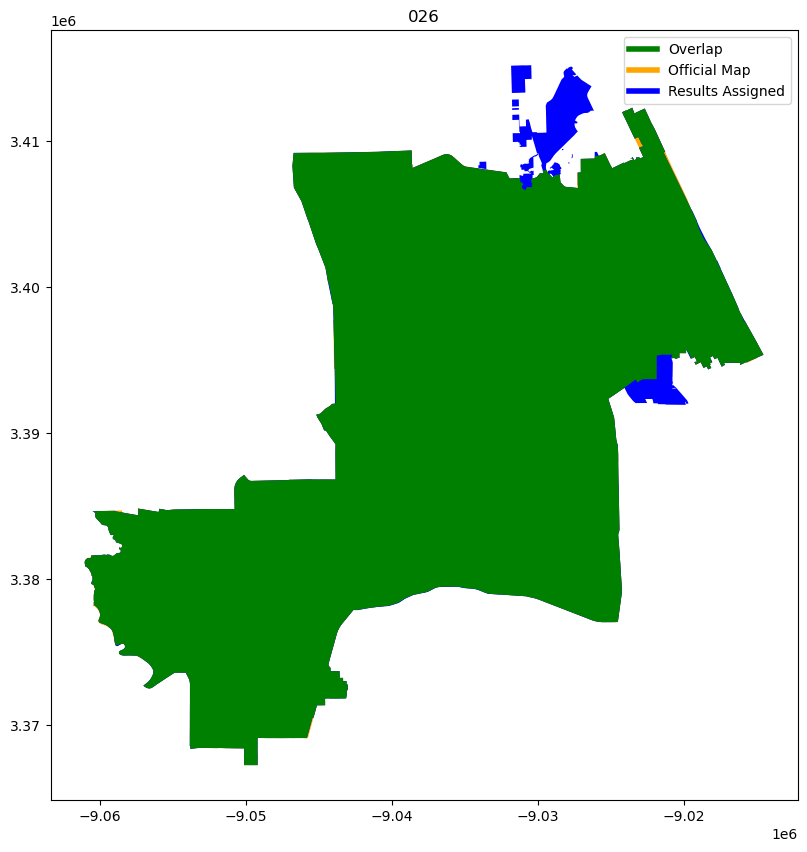

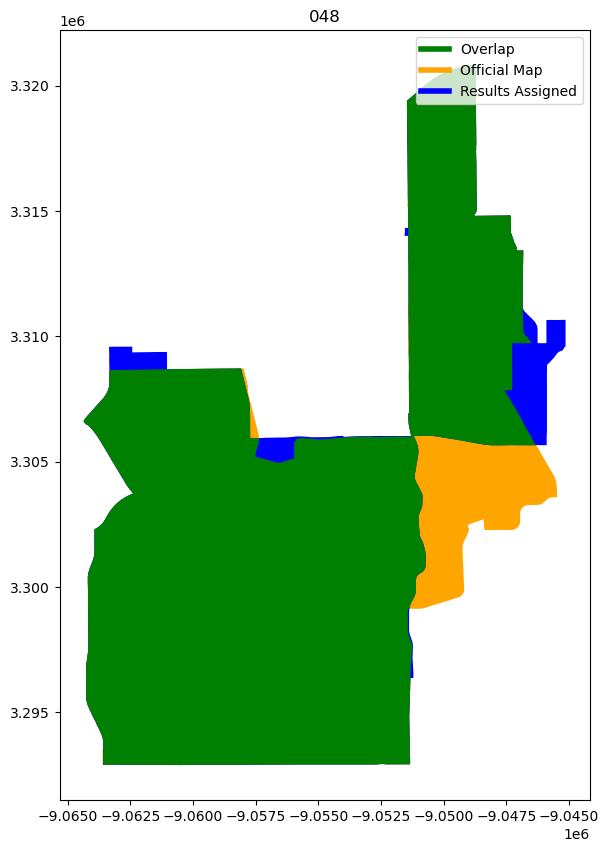

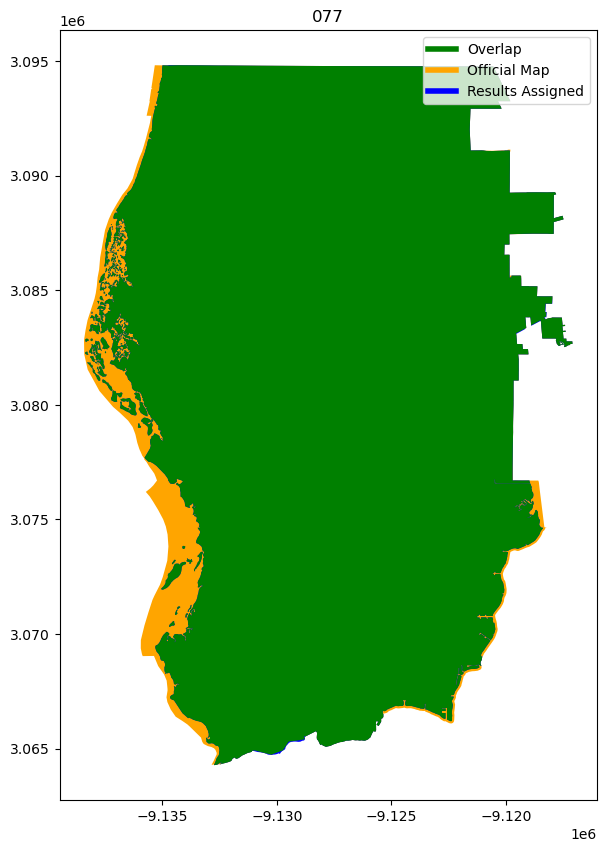

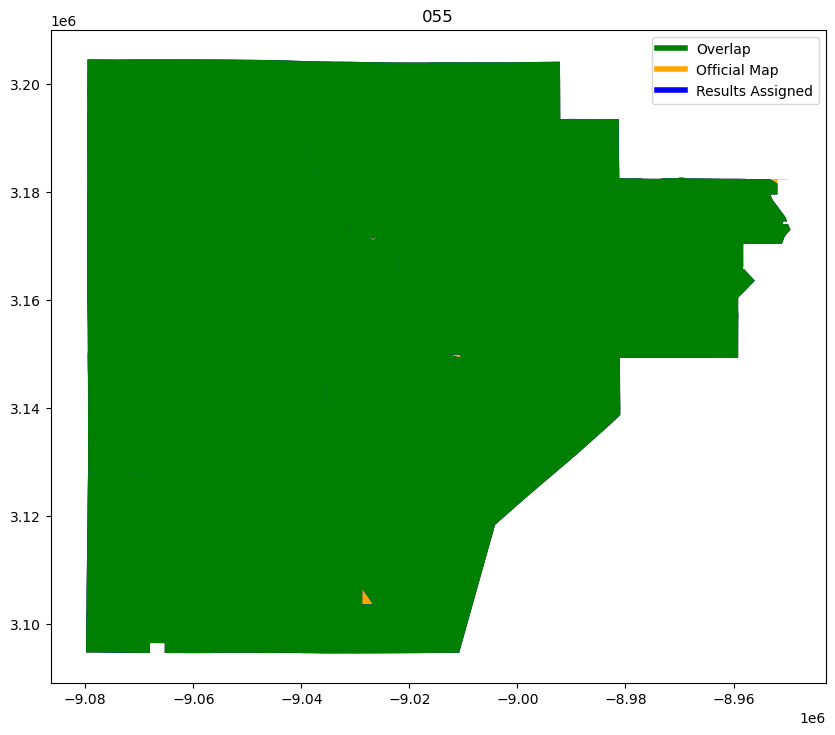

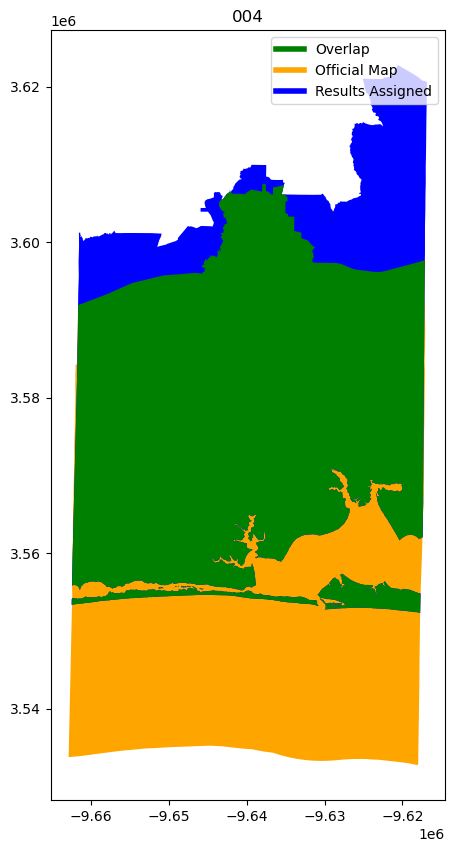

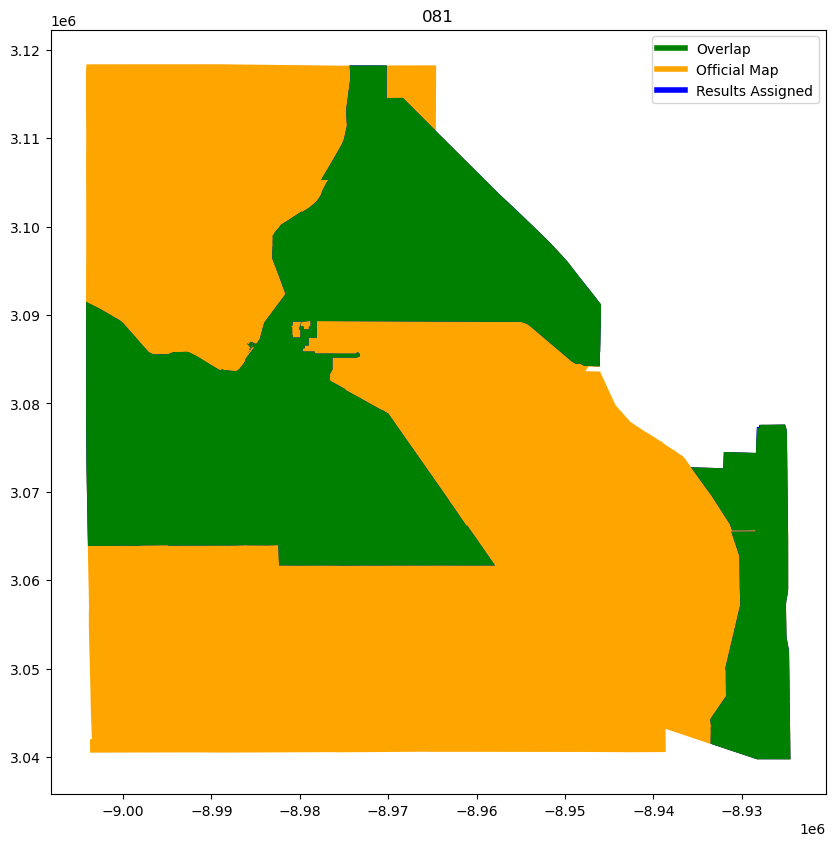

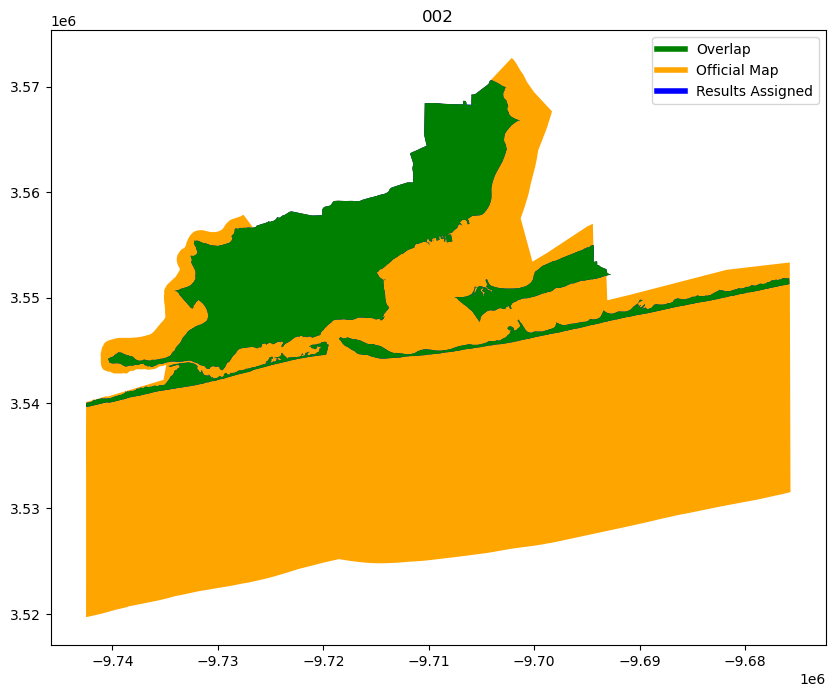

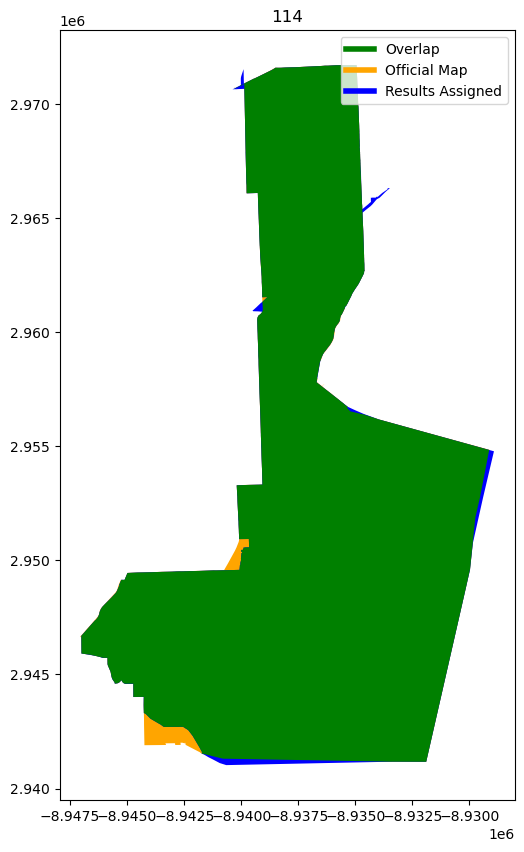

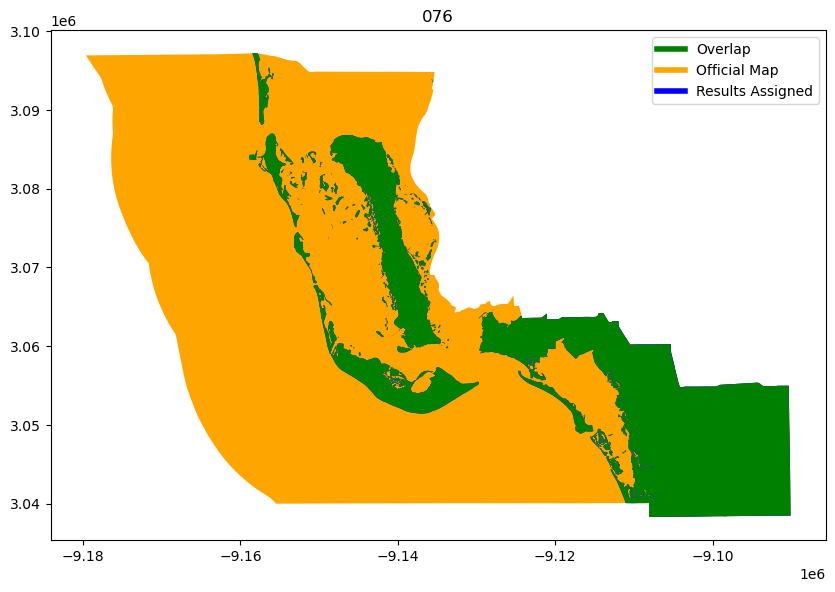

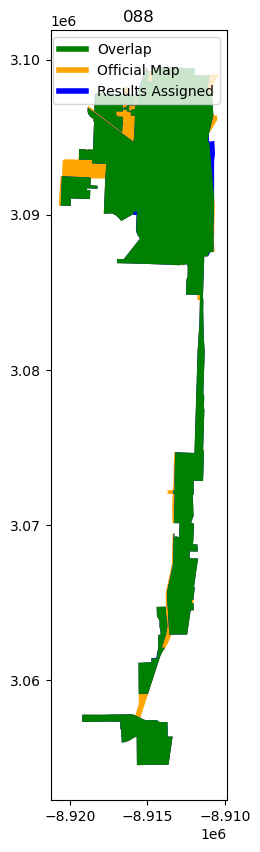

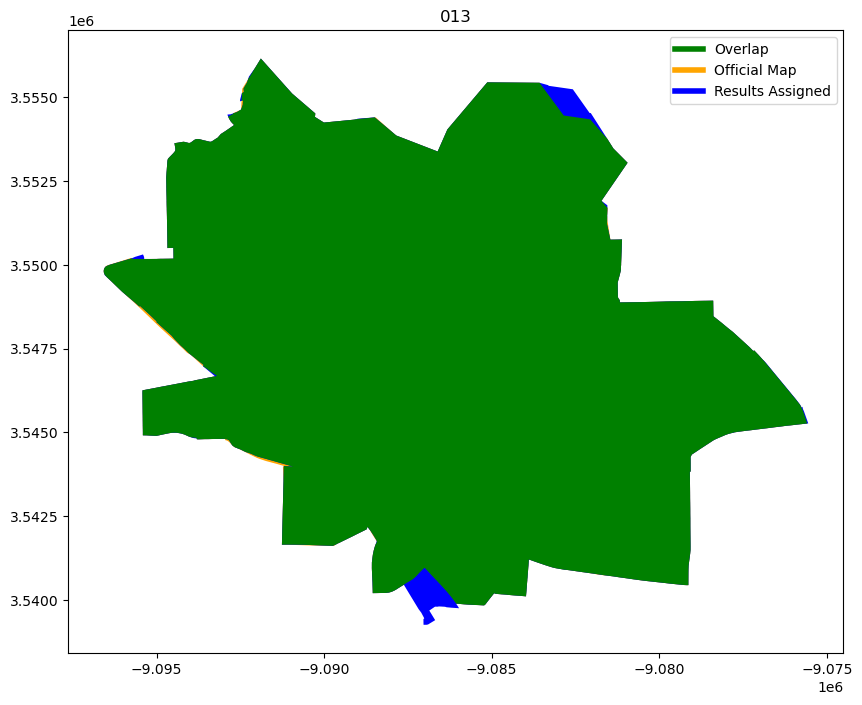

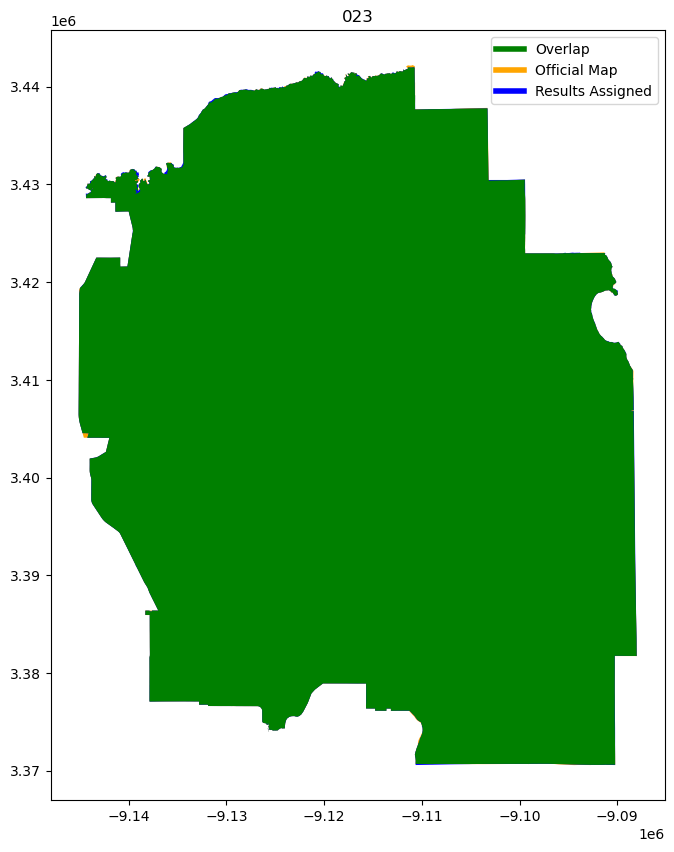

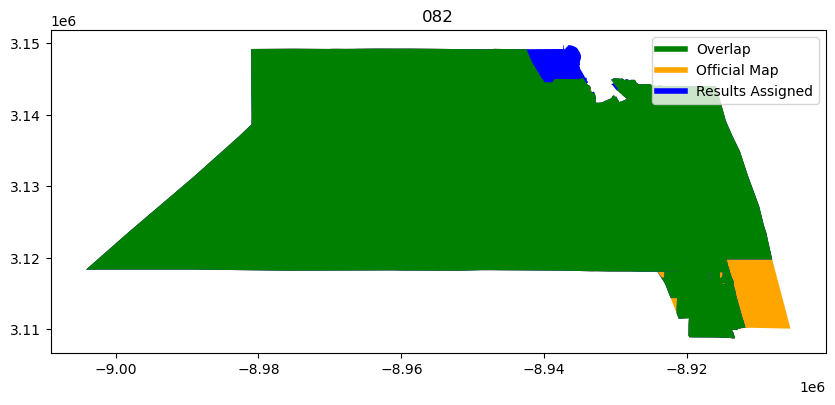

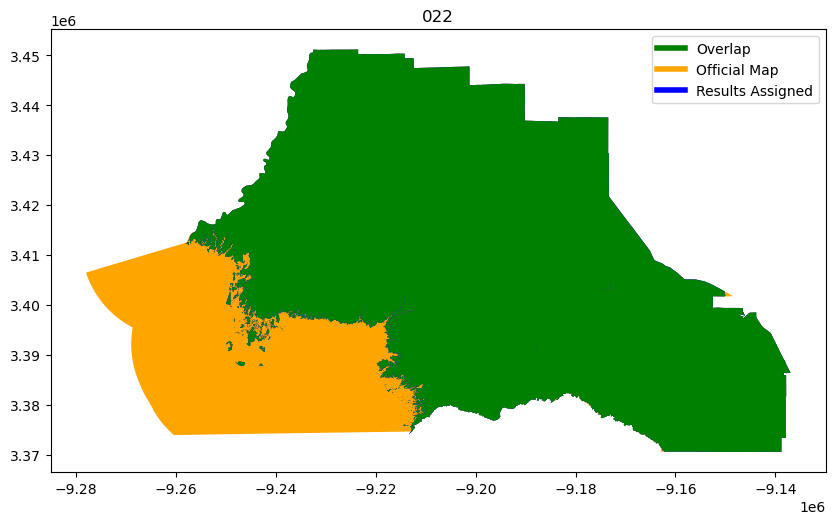

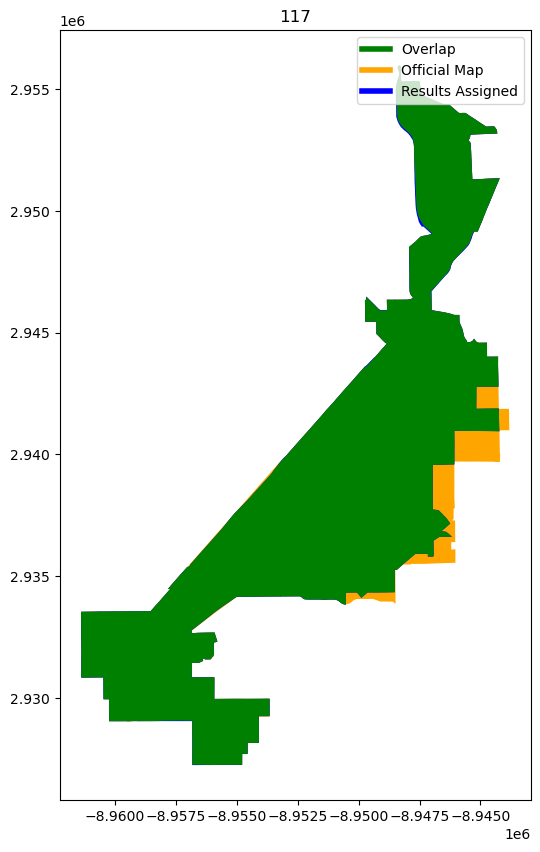

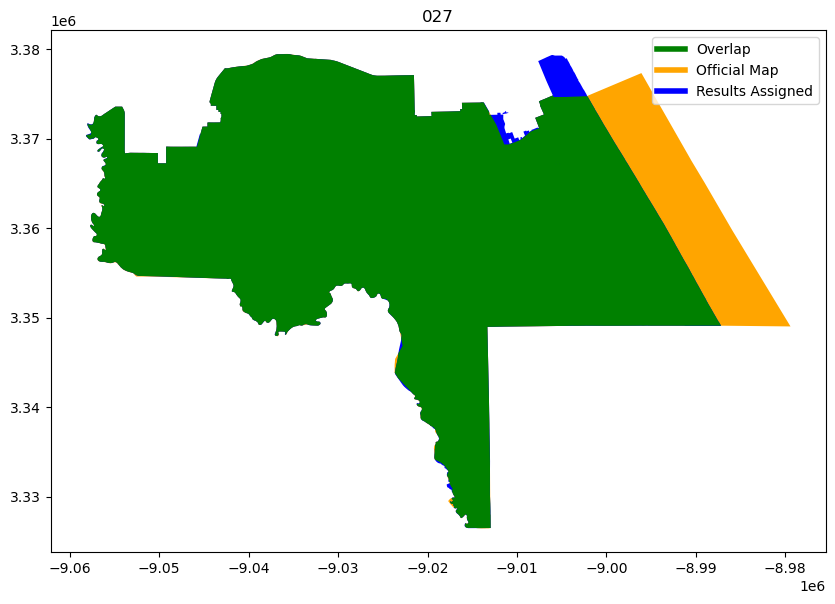

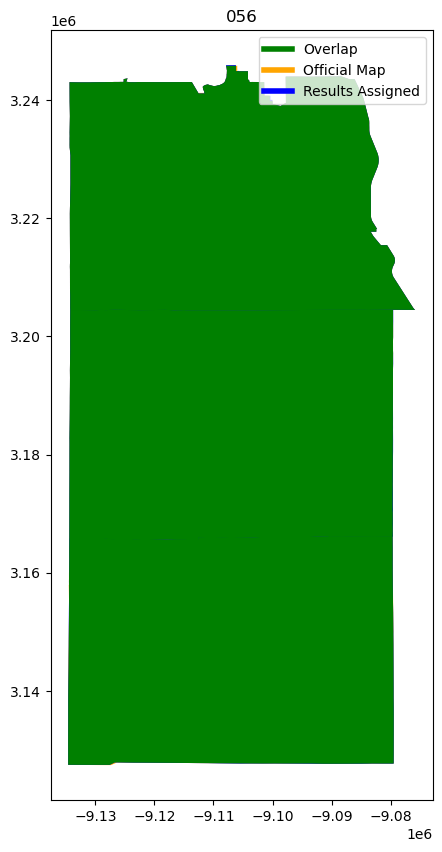

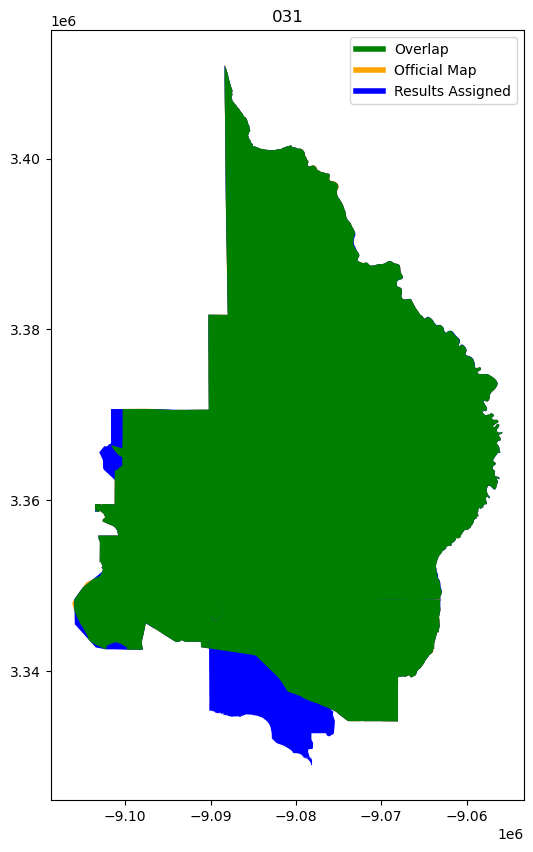

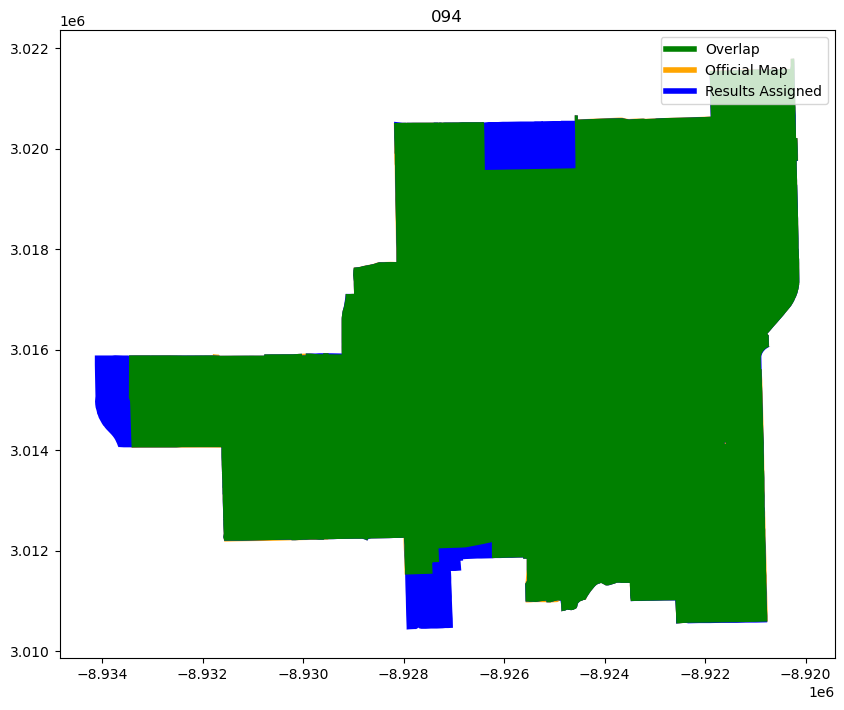

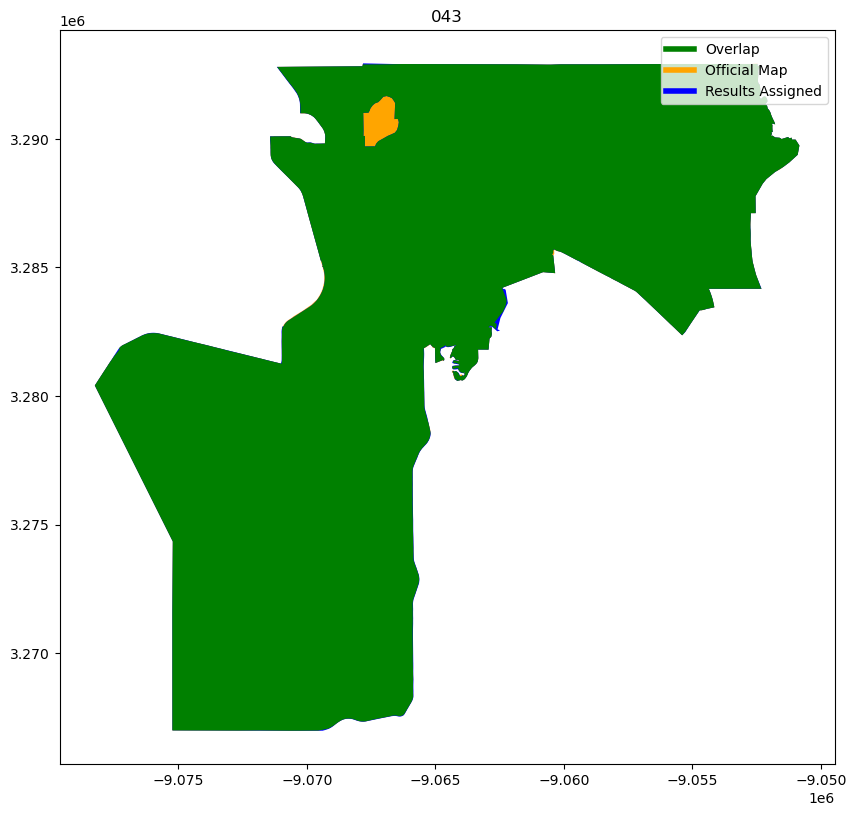

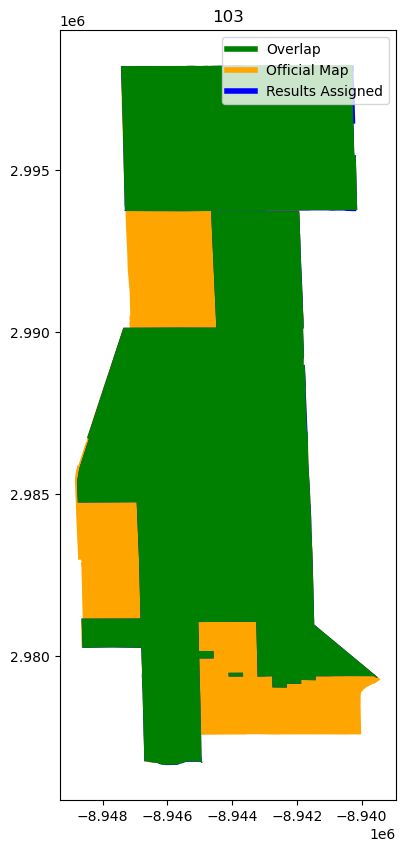

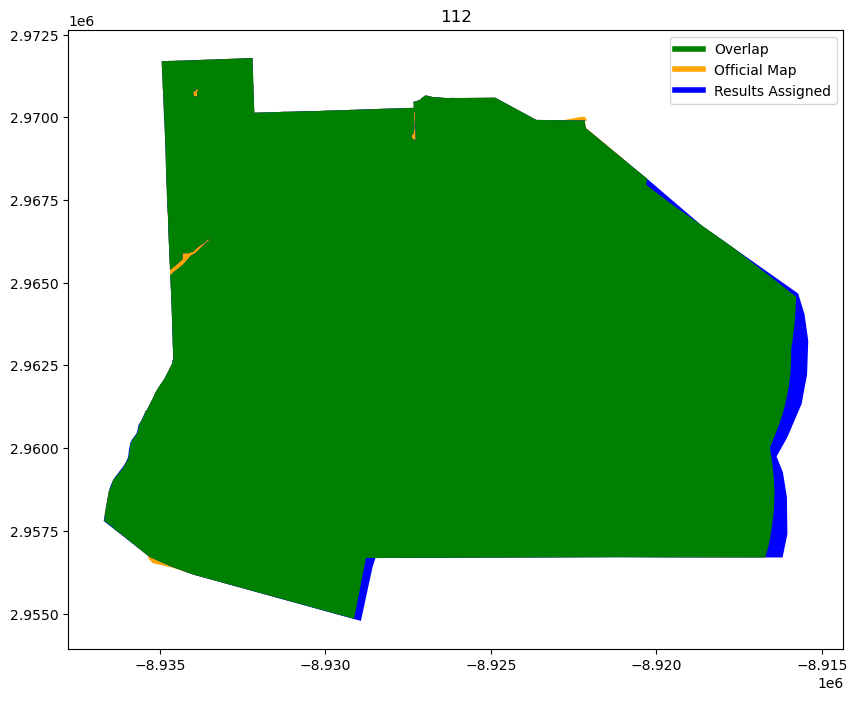

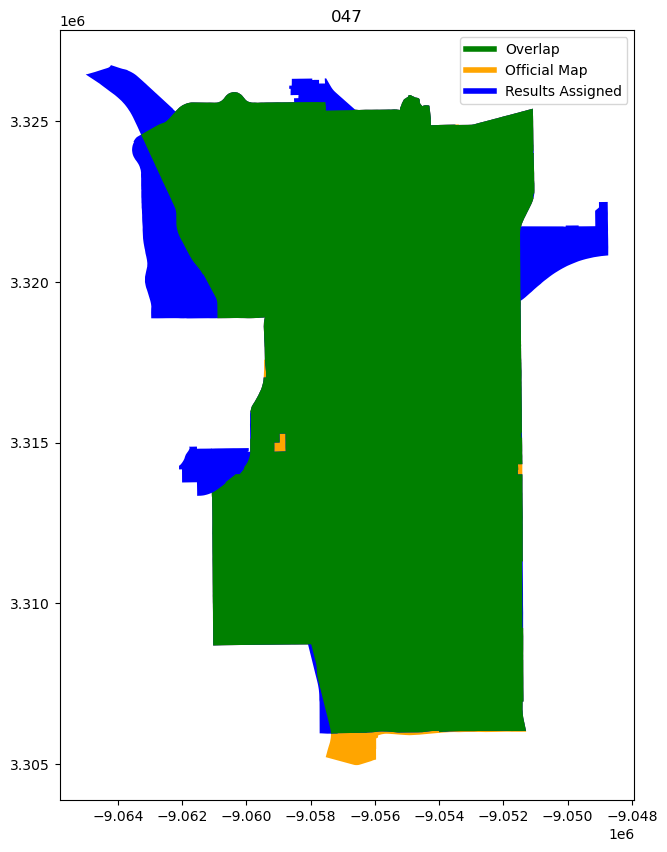

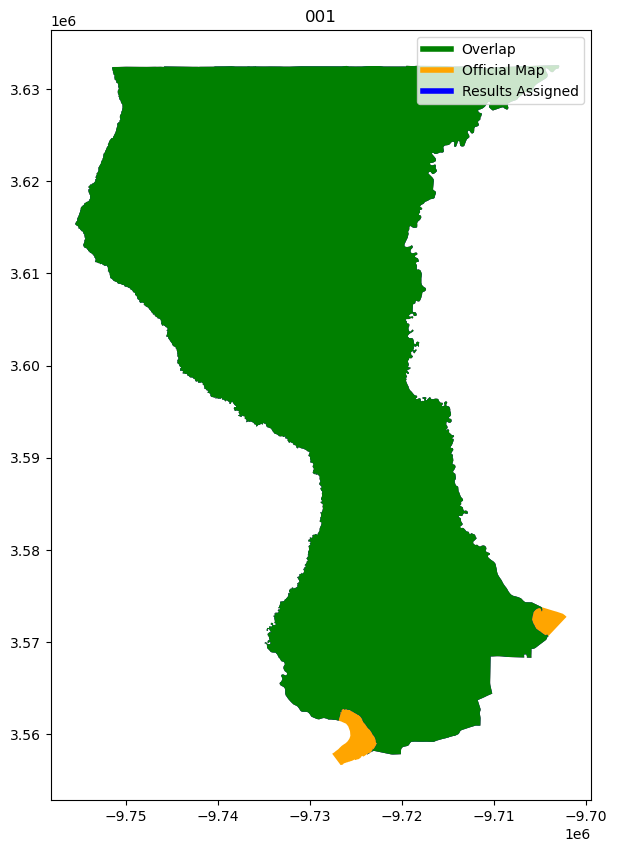

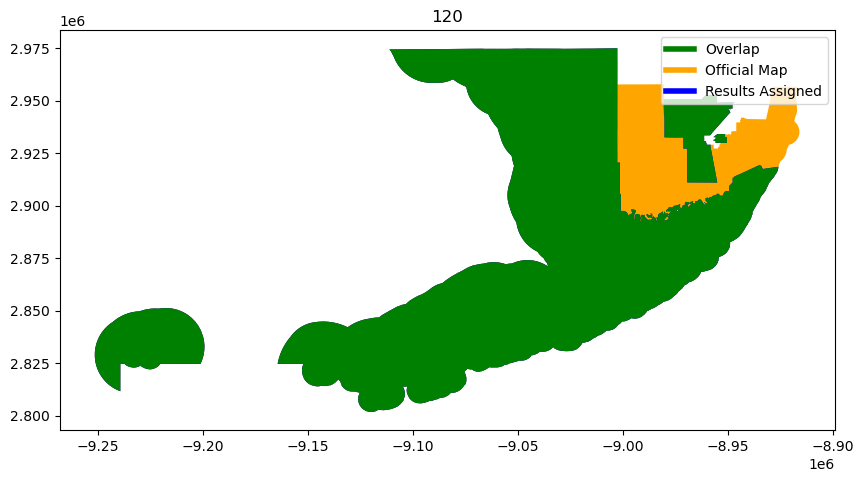

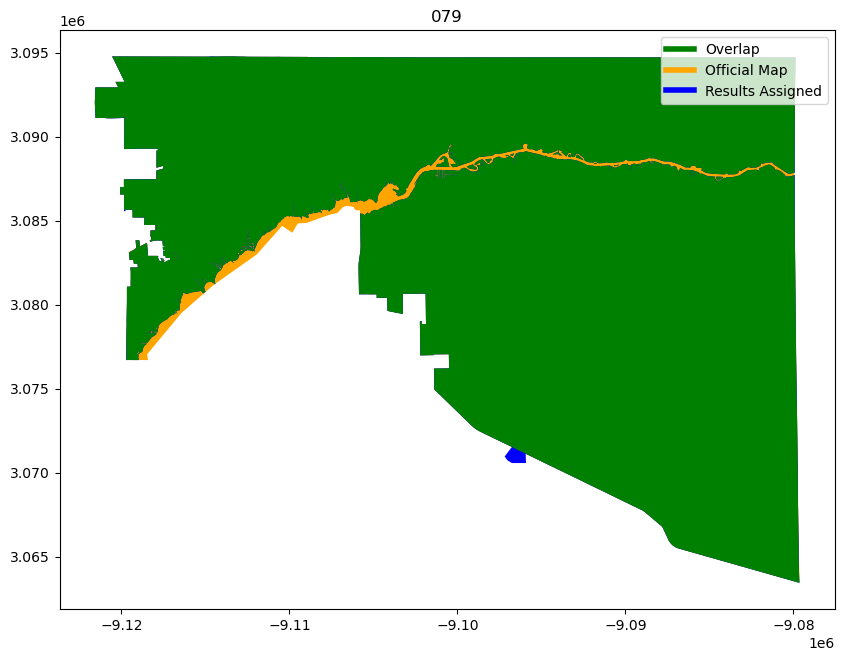

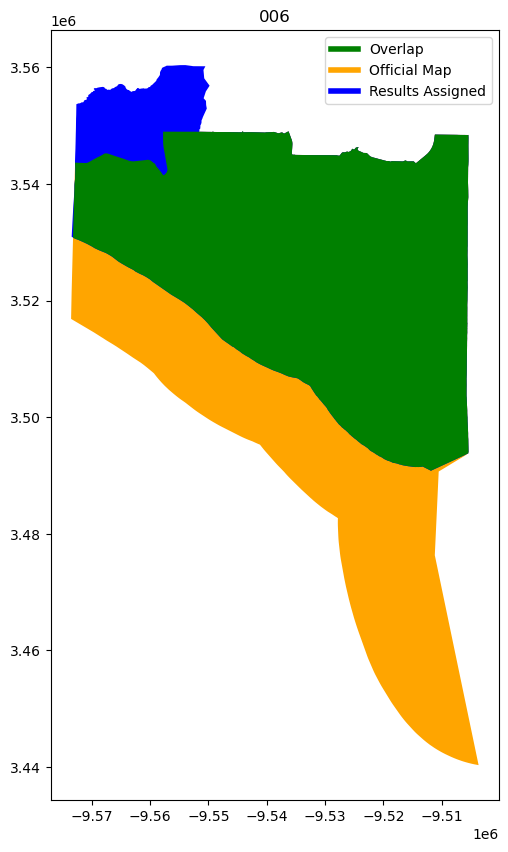

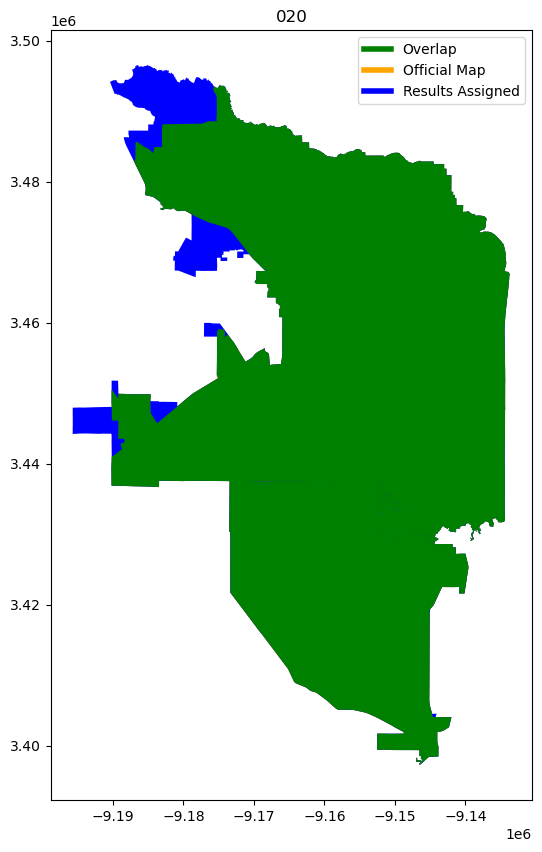

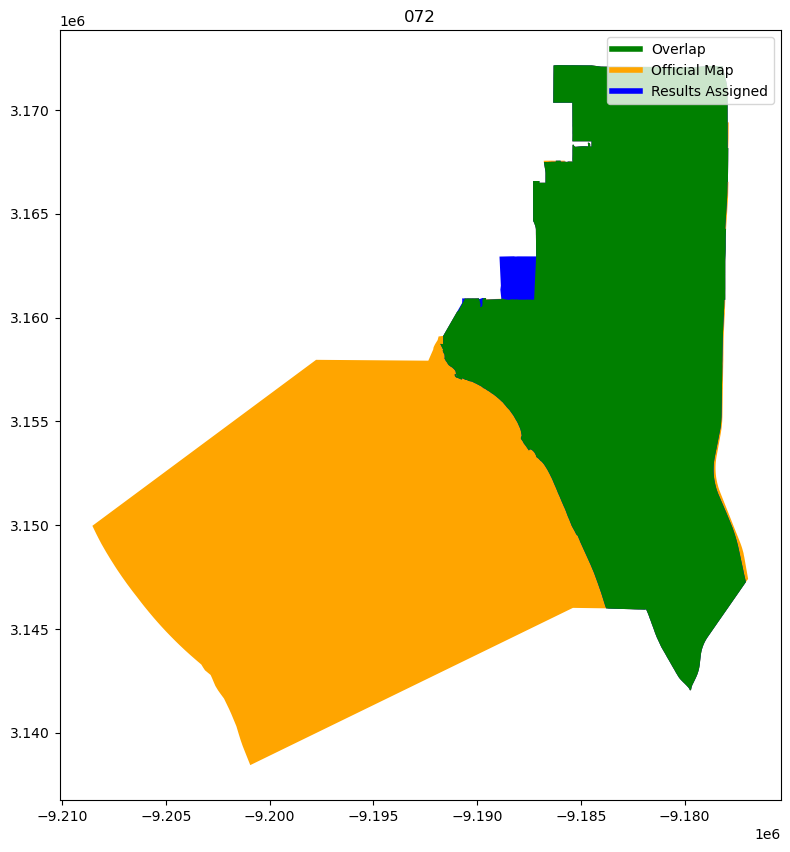

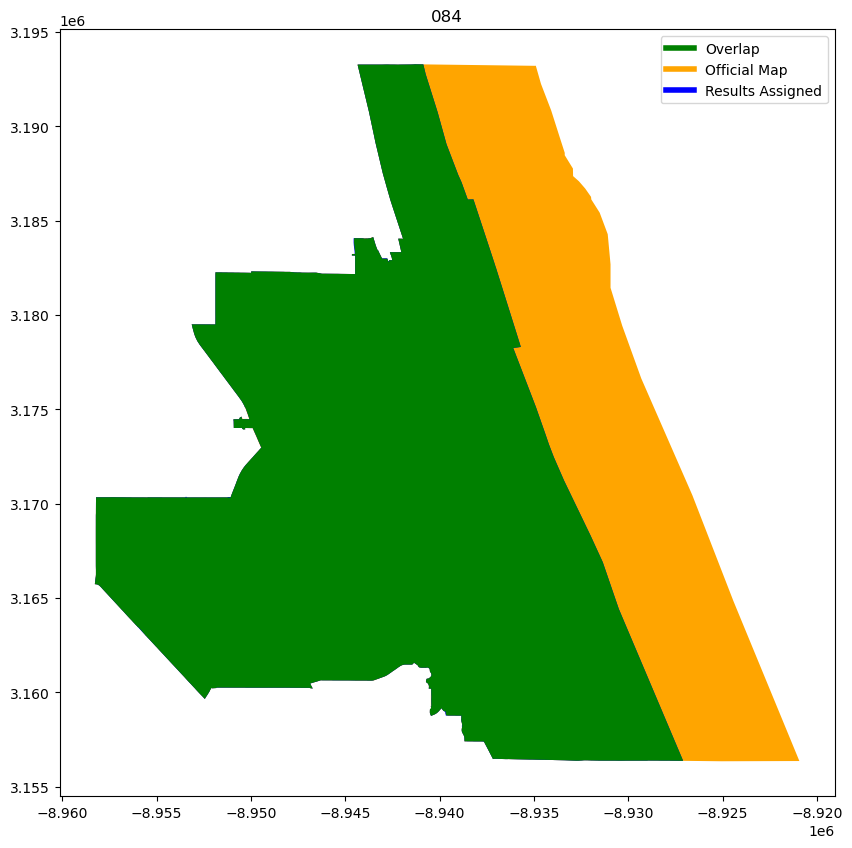

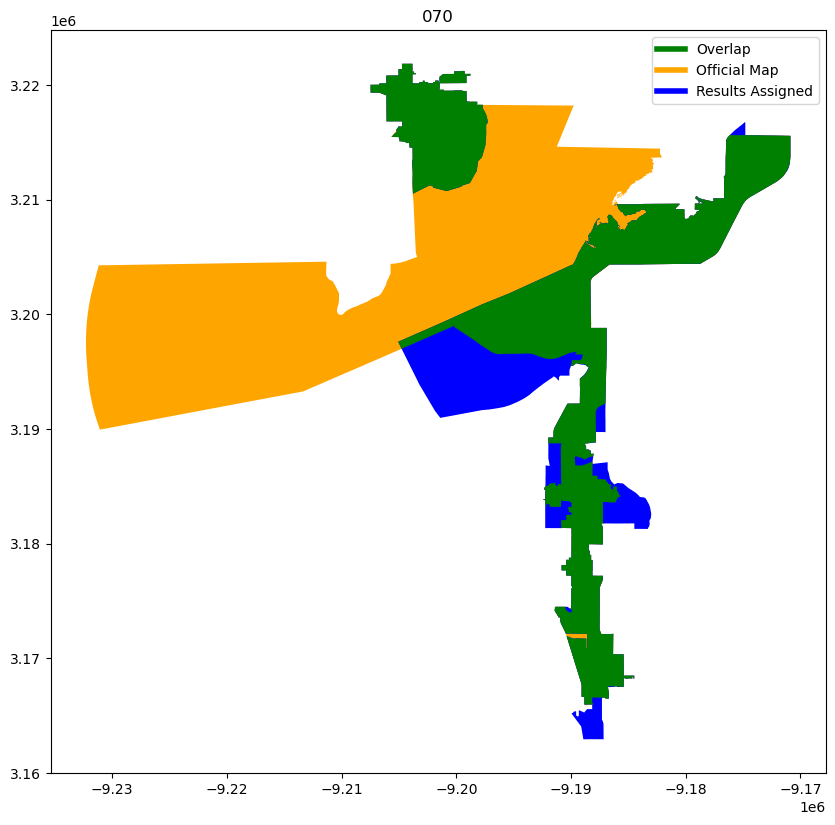

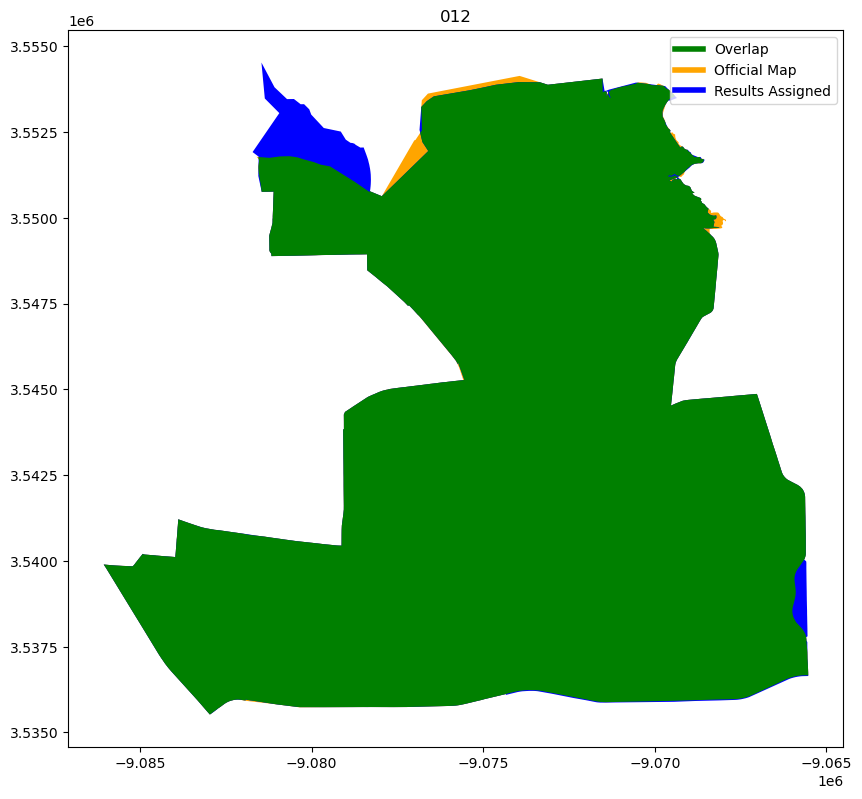

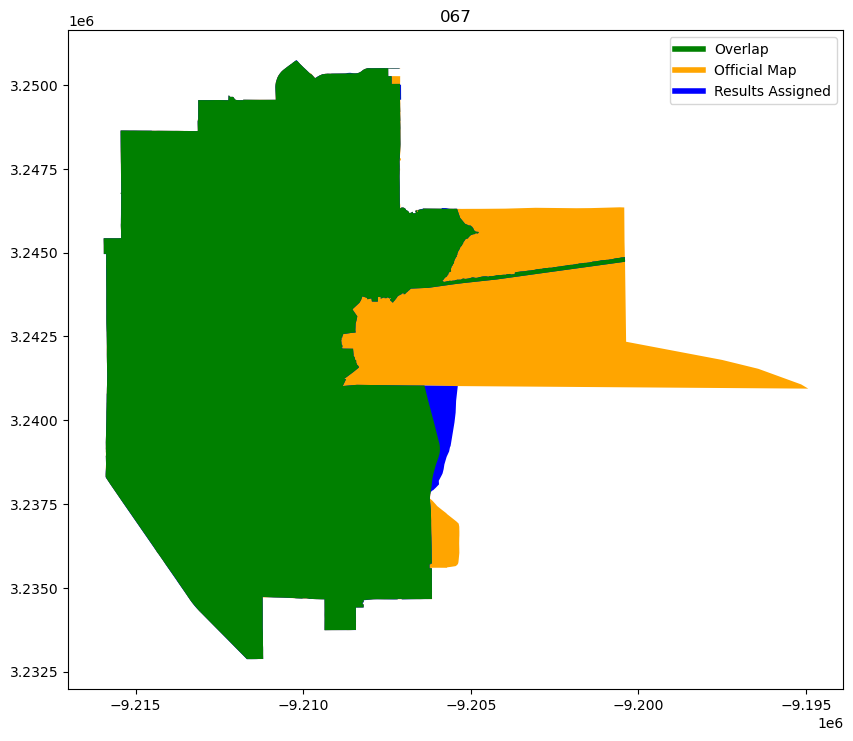

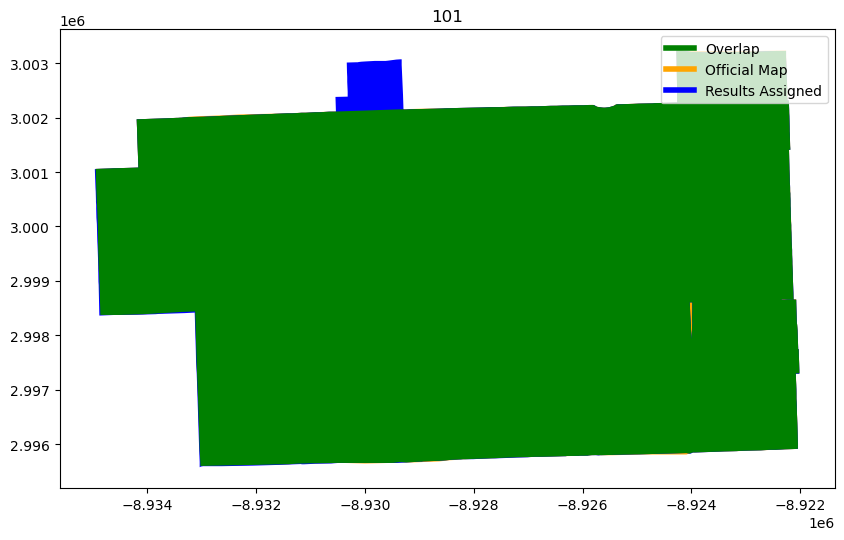

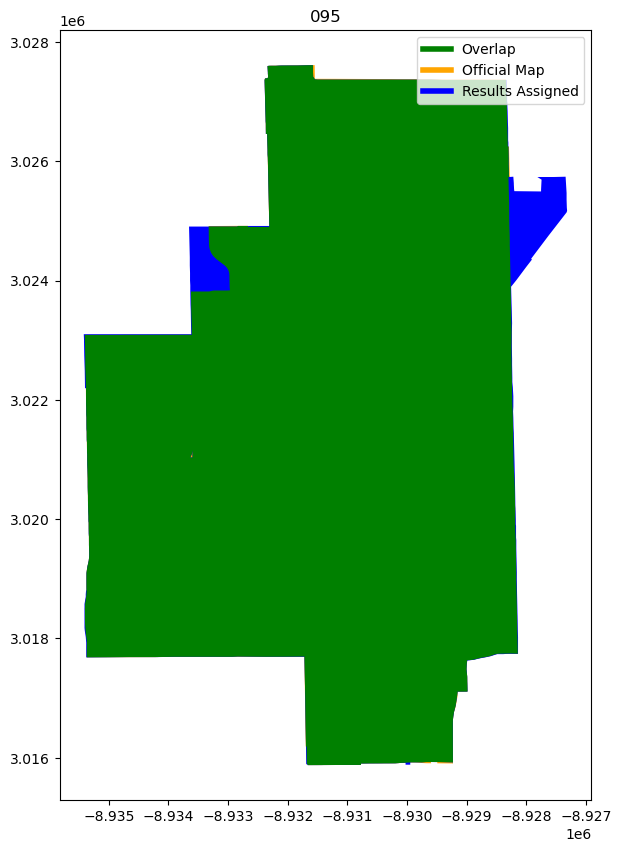

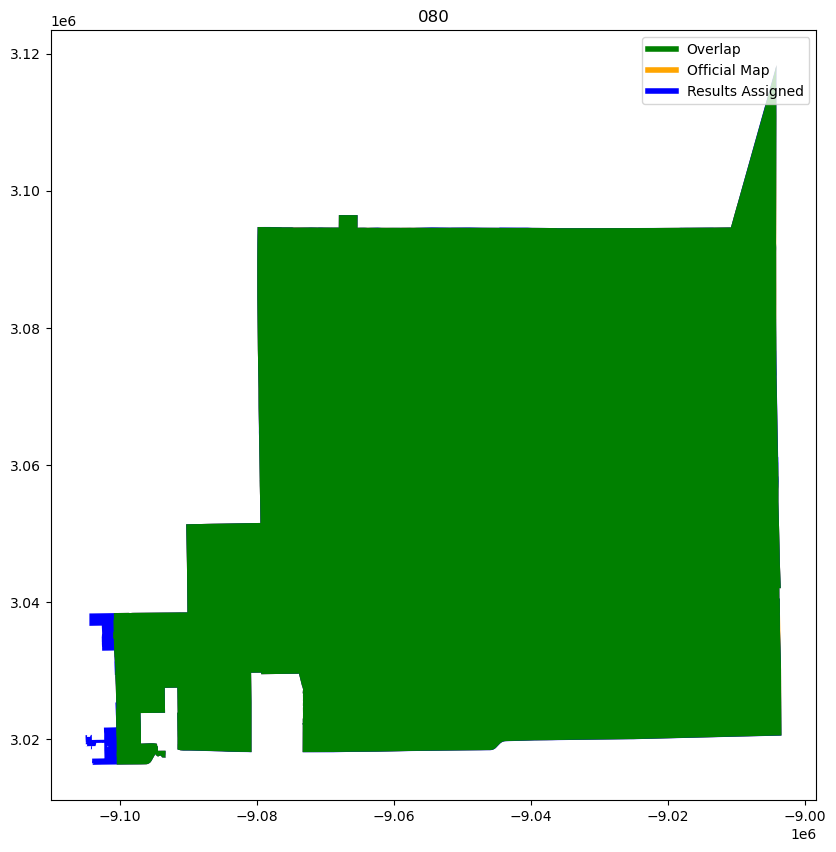

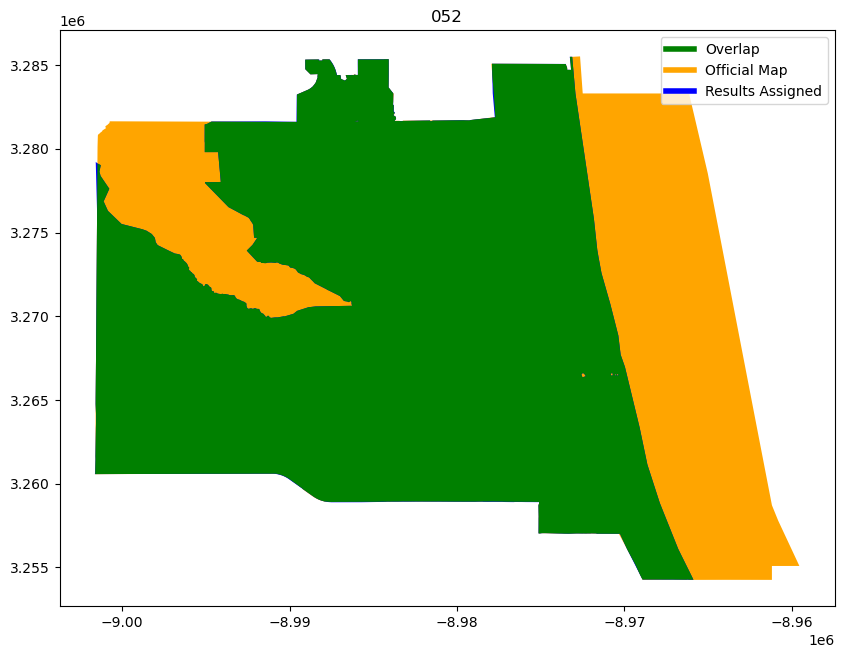

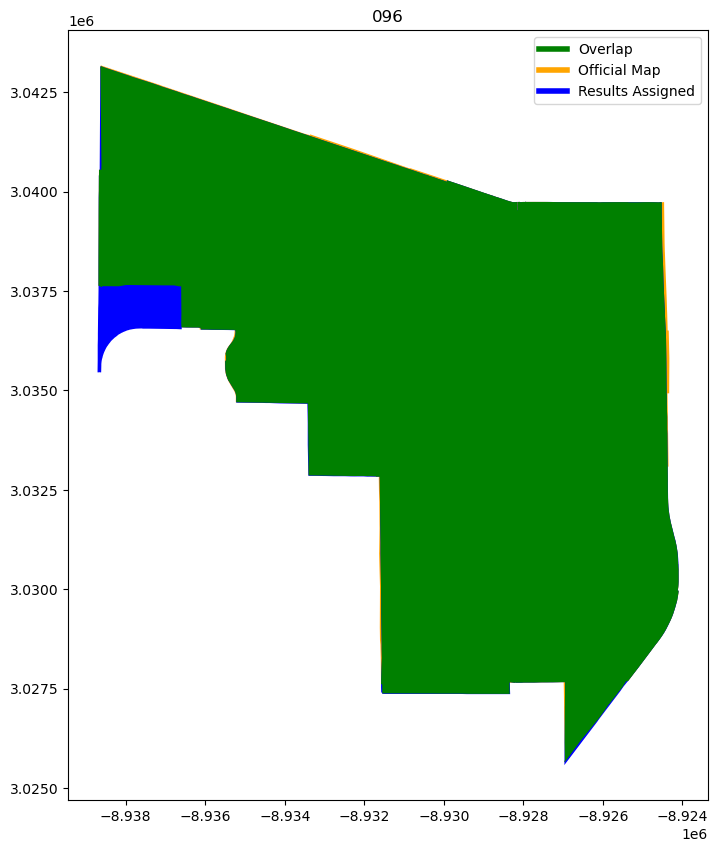

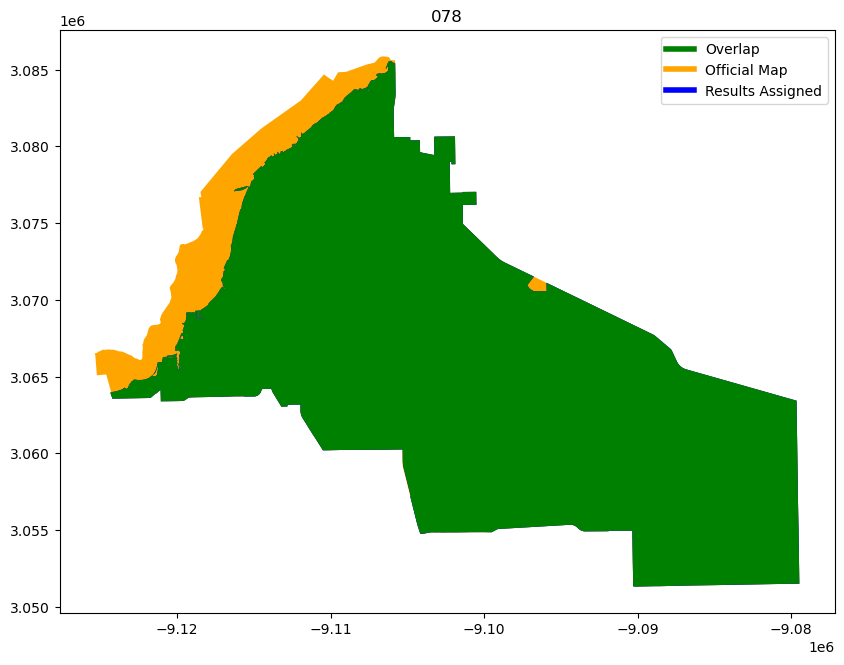

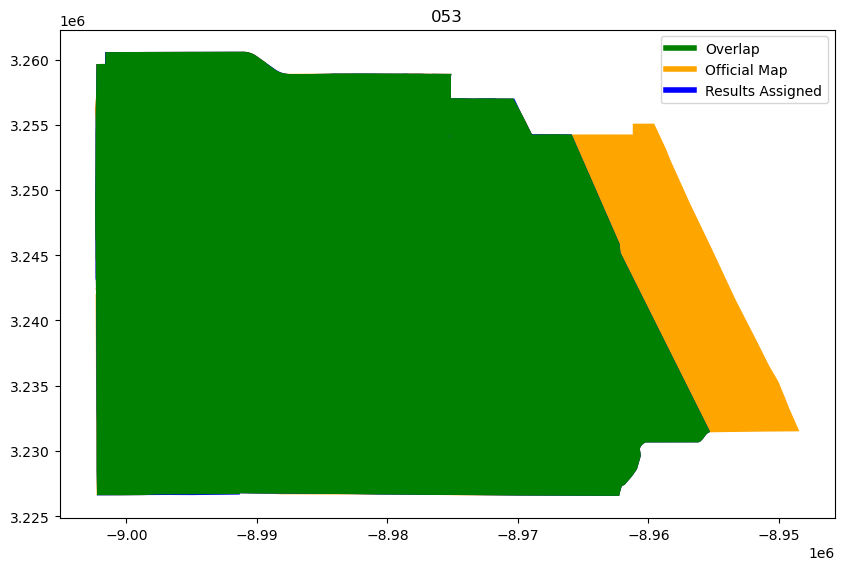

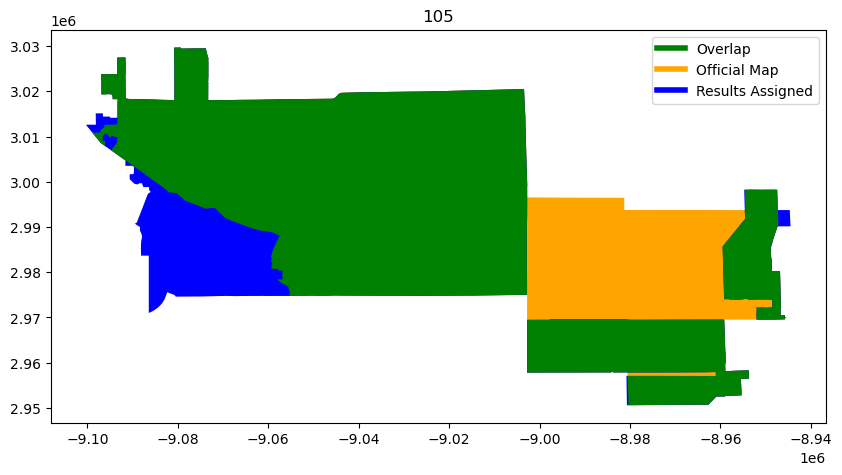

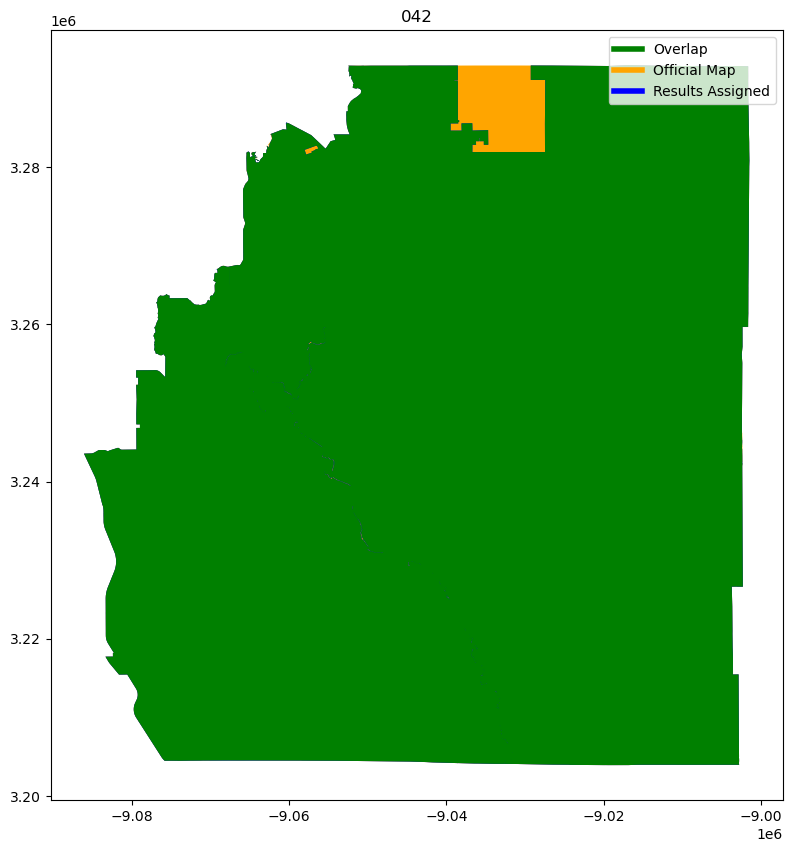

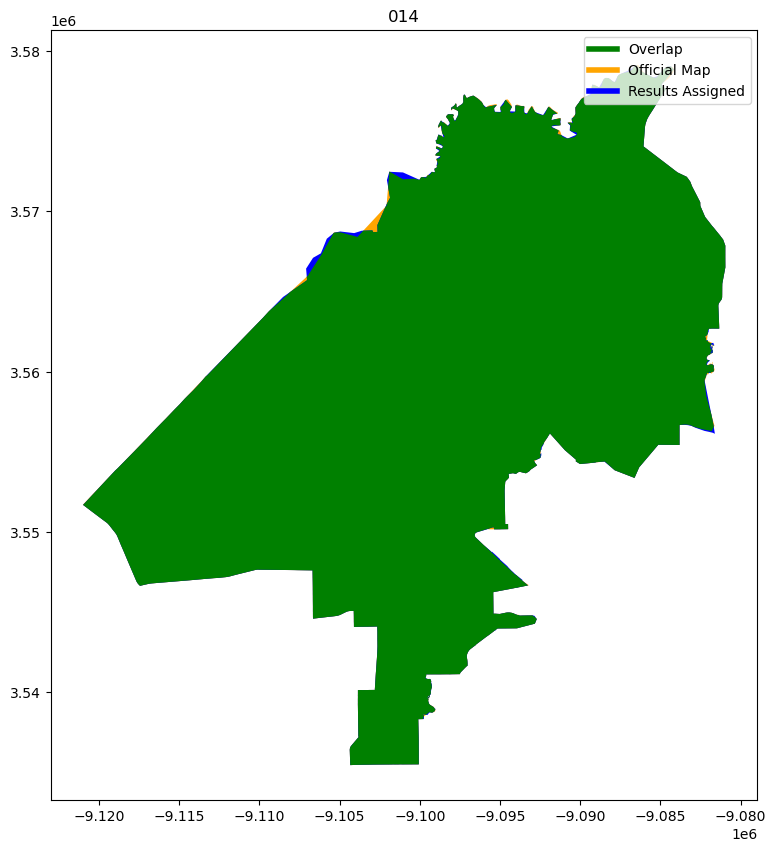

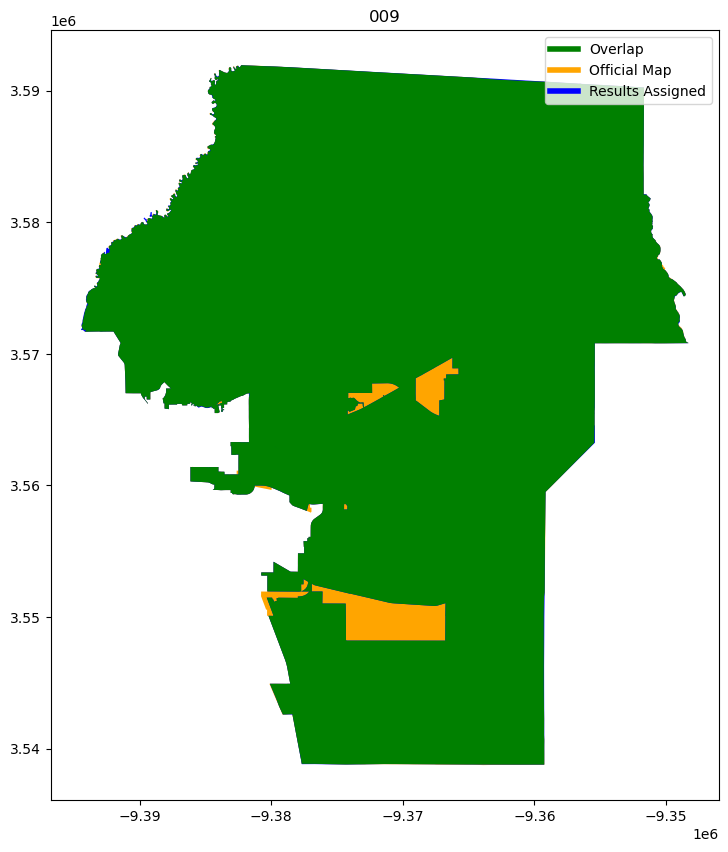

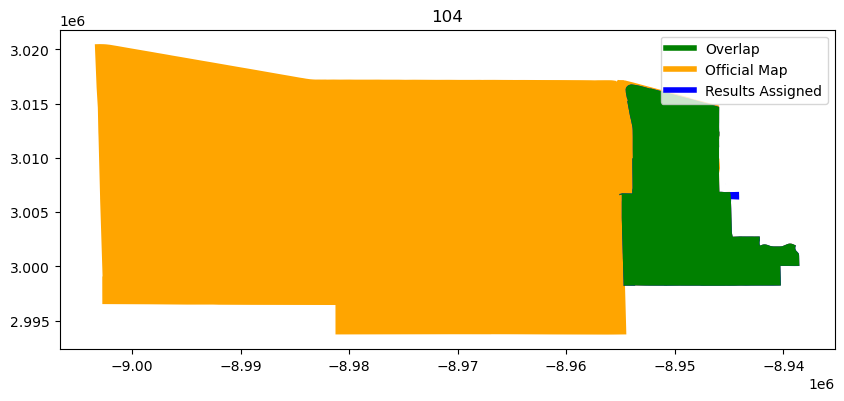

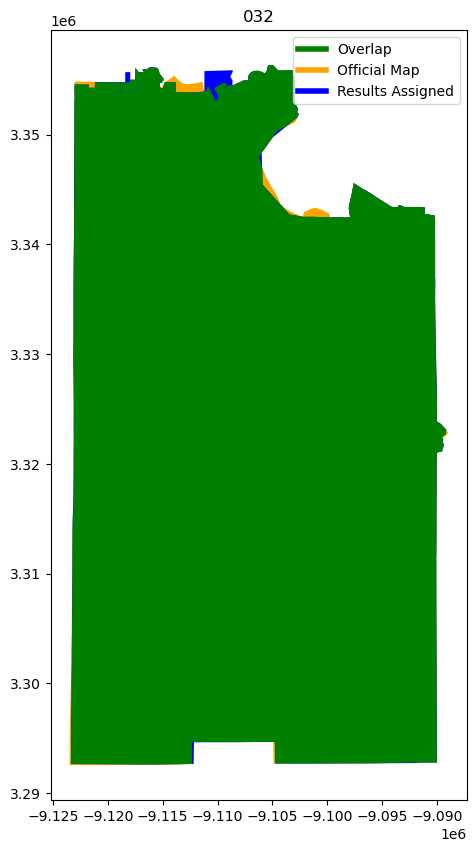

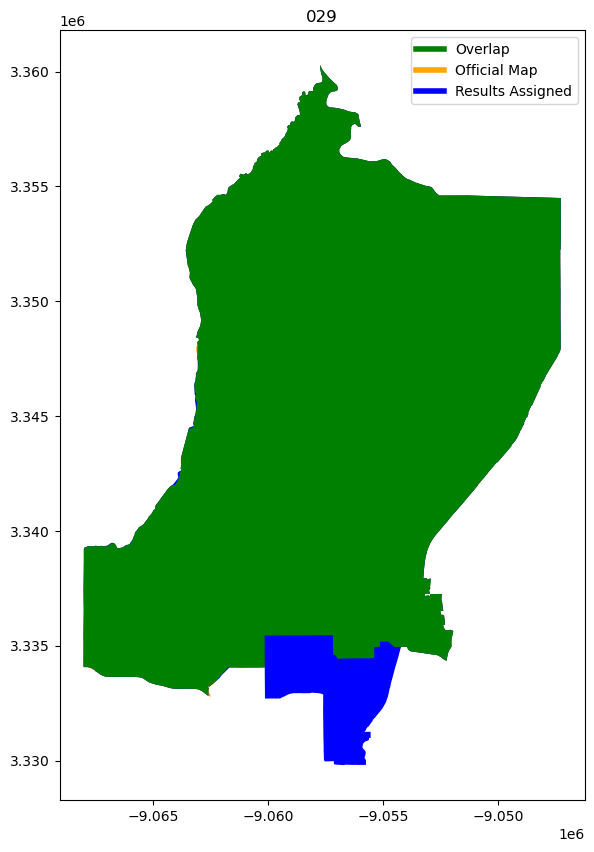

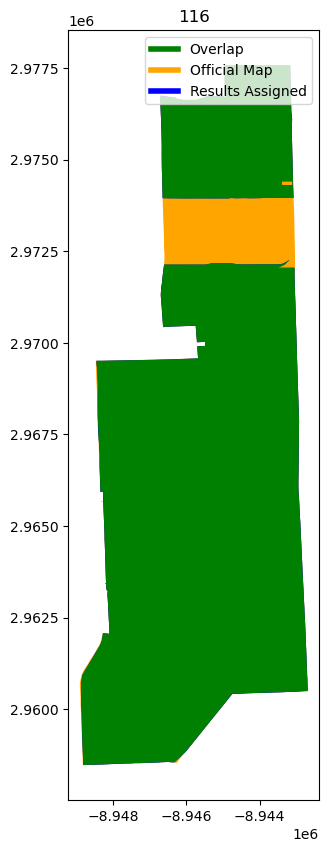

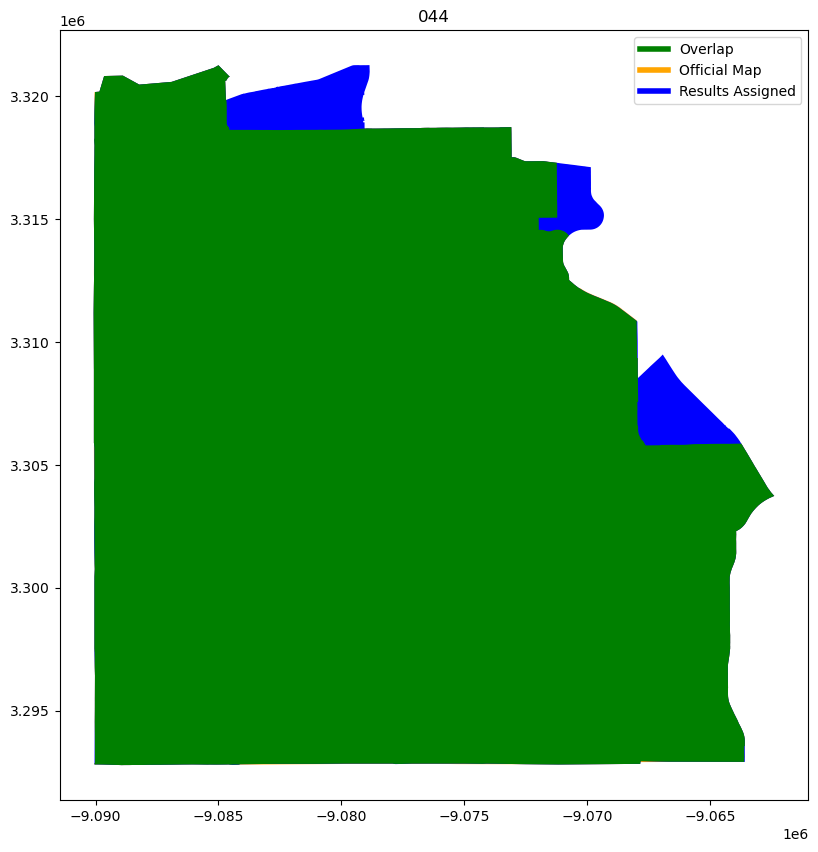

In [93]:
compare_geometries(fl_sldl_shapefile,filtered_results,"Official Map","Results Assigned","SLDL_DIST",area_threshold=.1)

## Add County FIPS column

In [94]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Florida"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"]=fips_file["County Name"].map({'De Soto':'Desoto','St Lucie':'St. Lucie', 'St Johns':'St. Johns'}).fillna(fips_file["County Name"])

#Create the dictionary
fl_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

join_attempt_two["County Name"] = np.where(join_attempt_two["County Name"].isna(), join_attempt_two["county"], join_attempt_two["County Name"])

join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict).fillna(join_attempt_two["County Name"])

fl_fips_dict_2 = {
  'BRO':'011',
  'FLA':'035',
  'HIL':'057',
  'PIN':'103',
  'BRE':'009',
  'CLL':'021',
  'LEO':'073',
  'DAD':'086',
  'PAL':'099',
  'PAS':'101',
}

join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict_2).fillna(join_attempt_two["COUNTYFP"])

join_attempt_two["COUNTYFP"].unique()

array(['001', '005', '011', '027', '043', '049', '051', '055', '057',
       '071', '075', '081', '091', '093', '095', '103', '105', '113',
       '115', '117', '111', '009', '021', '031', '033', '069', '073',
       '083', '085', '086', '087', '099', '127', '097'], dtype=object)

## Election Totals Checks

In [95]:
join_attempt_two = join_attempt_two.fillna(0)
for val in state_data_columns:
    join_attempt_two[val] = join_attempt_two[val].astype(int)
    
state_data_columns.sort()

In [96]:
official_totals = pd.read_csv("./raw-from-source/Election_Results/totals/08182020Election (1).txt",sep="\t",engine='python',index_col=None)

official_totals = official_totals[official_totals["OfficeDesc"].isin(['United States Representative','State Senator', 'State Representative'])]

office_rename_dict = {'United States Representative':'PCONG',
 'State Senator':'PSU',
 'State Representative':'PSL'}

official_totals["OfficeDesc"] = official_totals["OfficeDesc"].map(office_rename_dict).fillna(official_totals["OfficeDesc"])

official_totals["Juris1num"] = official_totals["Juris1num"].astype(str)
official_totals["Juris1num"] = official_totals["Juris1num"].str.zfill(3)

official_totals["Juris1num"] = np.where(official_totals["OfficeDesc"]=="PCONG", official_totals["Juris1num"].str[1:], official_totals["Juris1num"])
official_totals["Juris1num"] = np.where(official_totals["OfficeDesc"]=="PSU", official_totals["Juris1num"].str[1:], official_totals["Juris1num"])

official_totals.loc[official_totals["CanNameLast"]=="Chamberlin",'CanNameLast'] = "Chmberlin"
official_totals.loc[official_totals["CanNameLast"]=="Chase",'CanNameLast'] = 'Chse'

official_totals.loc[official_totals["CanNameLast"]=="Balderramos Robinson",'CanNameLast'] = "Robinson"

official_totals.loc[official_totals["CanNameLast"]=="Hayes Hinson",'CanNameLast'] = "Hinson"
official_totals.loc[official_totals["CanNameLast"]=="Dela Rosa",'CanNameLast'] = "Rosa Dela"
official_totals.loc[official_totals["CanNameLast"]=="Vilchez Santiago",'CanNameLast'] = "Santiago Vilchez"
official_totals.loc[official_totals["CanNameLast"]=="Clark", 'CanNameLast'] = 'Drew-Montez'
official_totals.loc[official_totals["CanNameLast"]== "Louis Jeune","CanNameLast"] = "Jeune Louis"
official_totals.loc[official_totals["CanNameLast"].str.contains("Bado"), "CanNameLast"] = "Jean-Pierre"
official_totals.loc[official_totals["CanNameLast"]== "Laguerre Hylton","CanNameLast"] = "Hylton Laguerre"
official_totals.loc[official_totals["CanNameLast"]== "Rebman Lopez","CanNameLast"] = "Lopez Rebman"

official_totals["CanNameLast_mod"] = official_totals["CanNameLast"].str[0:3].str.upper()

official_totals["cand_col_mod"] = official_totals["OfficeDesc"]+official_totals["Juris1num"]+official_totals["PartyCode"].str[0]+official_totals["CanNameLast_mod"]

official_totals_pivoted = pd.pivot_table(official_totals, index = 'CountyCode', columns = "cand_col_mod", values = "CanVotes", aggfunc = sum)

official_totals_pivoted.reset_index(inplace=True,drop=False)

official_totals_pivoted.rename(columns={"CountyCode" : "county"}, inplace = True)

official_totals_pivoted = official_totals_pivoted.fillna(0)

official_totals_pivoted.columns

state_house_cols = [i for i in official_totals_pivoted.columns if "PSL" in i]

official_totals_pivoted = official_totals_pivoted[["county"]+state_house_cols]

official_totals_pivoted["Tot_Votes"] = 0
for col in state_house_cols:
    official_totals_pivoted["Tot_Votes"] += official_totals_pivoted[col]
    
official_totals_pivoted = official_totals_pivoted[official_totals_pivoted["Tot_Votes"] > 0]


In [97]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tOfficial Totals: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tPrecinct Results: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)>0):
        print()
        print(diff_counties)

In [98]:
county_totals_check(official_totals_pivoted, join_attempt_two , state_data_columns,"county",full_print=False)

***Countywide Totals Check***

PSL001DMAT is equal across all counties
PSL001DSCO is equal across all counties
PSL001RHIL is equal across all counties
PSL001RSAL is equal across all counties
PSL002RAND is equal across all counties
PSL002RDOS is equal across all counties
PSL004RATK is equal across all counties
PSL004RHIN is equal across all counties
PSL004RMAN is equal across all counties
PSL004RTAL is equal across all counties
PSL006RLIN is equal across all counties
PSL006RTRU is equal across all counties
PSL009DGRI is equal across all counties
PSL009DTAN is equal across all counties
PSL012DBLI is equal across all counties
PSL012DCHI is equal across all counties
PSL012RMCA is equal across all counties
PSL012RYAR is equal across all counties


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated

PSL013DDAV is equal across all counties
PSL013DSMI is equal across all counties
PSL014DDAN is equal across all counties
PSL014DNIX is equal across all counties
PSL015DMCG is equal across all counties
PSL015DTHO is equal across all counties
PSL020DHIN is equal across all counties
PSL020DLON is equal across all counties
PSL022RHAR is equal across all counties
PSL022RRAN is equal across all counties
PSL023DROS is equal across all counties
PSL023DROW is equal across all counties
PSL026DHEN is equal across all counties
PSL026DSMI is equal across all counties
PSL027RBAR is equal across all counties
PSL027RBEN is equal across all counties
PSL027RDEN is equal across all counties
PSL028DBAK is equal across all counties
PSL028DMAN is equal across all counties
PSL029RDOW is equal across all counties
PSL029RPLA is equal across all counties


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated

PSL031DKAP is equal across all counties
PSL031DSTI is equal across all counties
PSL031RNOV is equal across all counties
PSL031RTRU is equal across all counties
PSL032DDUK is equal across all counties
PSL032DKER is equal across all counties
PSL032DMOR is equal across all counties
PSL042RHAW is equal across all counties
PSL042RLIE is equal across all counties
PSL042RSCO is equal across all counties
PSL042RVAL is equal across all counties
PSL043DARR is equal across all counties
PSL043DBAR is equal across all counties
PSL043DIRI is equal across all counties
PSL043DJEN is equal across all counties
PSL043DLYL is equal across all counties
PSL043DRAN is equal across all counties
PSL044DFAR is equal across all counties
PSL044DTHO is equal across all counties
PSL044RBLA is equal across all counties
PSL044RPOR is equal across all counties


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated

PSL047RMOR is equal across all counties
PSL047RSIS is equal across all counties
PSL048DMOR is equal across all counties
PSL048DPEN is equal across all counties
PSL048DROC is equal across all counties
PSL048DSAN is equal across all counties
PSL048DTSO is equal across all counties
PSL052RALT is equal across all counties
PSL052RNYE is equal across all counties
PSL053RADK is equal across all counties
PSL053RFIN is equal across all counties
PSL055RHAN is equal across all counties
PSL055RTUC is equal across all counties
PSL056DBAU is equal across all counties
PSL056DDAV is equal across all counties


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated

PSL059RKUS is equal across all counties
PSL059ROWE is equal across all counties
PSL067DDOU is equal across all counties
PSL067DHEN is equal across all counties
PSL070DBEL is equal across all counties
PSL070DGRI is equal across all counties
PSL070DOLI is equal across all counties
PSL070DRAY is equal across all counties
PSL072RBAR is equal across all counties
PSL072RMCF is equal across all counties
PSL072RMIL is equal across all counties
PSL076RBOT is equal across all counties
PSL076RMAU is equal across all counties
PSL077RBLA is equal across all counties
PSL077RGIA is equal across all counties
PSL078RLOL is equal across all counties
PSL078RLYN is equal across all counties
PSL078RPER is equal across all counties
PSL079RALL is equal across all counties
PSL079RROA is equal across all counties
PSL080RDOT is equal across all counties


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated

PSL080RDRE is equal across all counties
PSL080RMEL is equal across all counties
PSL081DSKI is equal across all counties
PSL081DWEI is equal across all counties
PSL081RBAN is equal across all counties
PSL081RMOU is equal across all counties
PSL082RDOM is equal across all counties
PSL082RKOZ is equal across all counties
PSL082RSNY is equal across all counties
PSL084RTRA is equal across all counties
PSL084RVAR is equal across all counties
PSL088DHAR is equal across all counties
PSL088DJAC is equal across all counties
PSL088DJEU is equal across all counties
PSL088DOST is equal across all counties
PSL088DTHO is equal across all counties
PSL094DDUB is equal across all counties
PSL094DMAN is equal across all counties
PSL095DOMP is equal across all counties


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated

PSL095DROG is equal across all counties
PSL096DFAR is equal across all counties
PSL096DHUN is equal across all counties
PSL101DJOH is equal across all counties
PSL101DMOH is equal across all counties
PSL101DWOO is equal across all counties
PSL102DHIN is equal across all counties
PSL102DROB is equal across all counties
PSL102DTIS is equal across all counties
PSL102DWIL is equal across all counties
PSL103RFAB is equal across all counties
PSL103RROD is equal across all counties
PSL104DBAR is equal across all counties
PSL104DWRI is equal across all counties
PSL105DEST is equal across all counties
PSL105DPOR is equal across all counties
PSL105RBAR is equal across all counties
PSL105RBOR is equal across all counties
PSL105RPOT is equal across all counties
PSL107DBEN is equal across all counties
PSL107DHAR is equal across all counties
PSL108DBOS is equal across all counties
PSL108DHAR is equal across all counties
PSL108DJOS is equal across all counties
PSL112RBAR is equal across all counties


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27167/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated

### Note: In order to make these differences match, the following votes were added /subtracted in Seminole county above

In [99]:
sem_diff

,pct_std,County Code (Three-character abbreviation),County Name,PSL076RBOT,PSL088DJAC,PSL002RAND,PSL043DBAR,PSL120RSUA,PSL009DTAN,PSL044DFAR,PSL014DNIX,PSL095DOMP,PSL009DGRI,PSL101DMOH,PSL001DSCO,PSL105RPOT,PSL042RVAL,PSL094DDUB,PSL101DJOH,PSL112RBAR,PSL044RPOR,PSL077RBLA,PSL082RDOM,PSL043DIRI,PSL088DTHO,PSL078RLYN,PSL096DHUN,PSL107DBEN,PSL012RYAR,PSL012RMCA,PSL002RDOS,PSL031DSTI,PSL023DROS,PSL013DSMI,PSL048DMOR,PSL084RTRA,PSL116RPER,PSL059RKUS,PSL105RBOR,PSL102DWIL,PSL067DDOU,PSL031DKAP,PSL102DHIN,PSL042RLIE,PSL072RBAR,PSL108DJOS,PSL080RDRE,PSL084RVAR,PSL094DMAN,PSL012DBLI,PSL056DBAU,PSL027RBEN,PSL026DSMI,PSL102DROB,PSL072RMCF,PSL044RBLA,PSL001DMAT,PSL042RHAW,PSL116RGAR,PSL042RSCO,PSL108DBOS,PSL044DTHO,PSL117DFOR,PSL043DJEN,PSL120RMOO,PSL056DDAV,PSL095DROG,PSL072RMIL,PSL076RMAU,PSL105DEST,PSL015DMCG,PSL006RTRU,PSL114DJEA,PSL004RHIN,PSL078RPER,PSL047RSIS,PSL117DHYL,PSL022RHAR,PSL082RSNY,PSL004RTAL,PSL048DROC,PSL055RTUC,PSL070DBEL,PSL031RTRU,PSL081DSKI,PSL117DCHA,PSL047RMOR,PSL014DDAN,PSL043DARR,PSL080RMEL,PSL028DMAN,PSL032DKER,PSL029RDOW,PSL053RADK,PSL101DWOO,PSL070DOLI,PSL052RNYE,PSL102DTIS,PSL105DPOR,PSL081DWEI,PSL059ROWE,PSL067DHEN,PSL070DRAY,PSL070DGRI,PSL001RSAL,PSL077RGIA,PSL001RHIL,PSL104DWRI,PSL055RHAN,PSL048DPEN,PSL103RROD,PSL088DHAR,PSL028DBAK,PSL026DHEN,PSL004RMAN,PSL105RBAR,PSL088DJEU,PSL079RALL,PSL053RFIN,PSL120RLOP,PSL043DRAN,PSL023DROW,PSL082RKOZ,PSL104DBAR,PSL020DLON,PSL078RLOL,PSL112RPAL,PSL108DHAR,PSL022RRAN,PSL032DMOR,PSL096DFAR,PSL048DSAN,PSL004RATK,PSL081RBAN,PSL029RPLA,PSL088DOST,PSL081RMOU,PSL079RROA,PSL012DCHI,PSL032DDUK,PSL031RNOV,PSL006RLIN,PSL114DLOY,PSL043DLYL,PSL015DTHO,PSL052RALT,PSL103RFAB,PSL048DTSO,PSL013DDAV,PSL107DHAR,PSL080RDOT,PSL027RBAR,PSL020DHIN,PSL027RDEN
0,SEMDIFF,SEM,Seminole,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [100]:
join_attempt_two = join_attempt_two[["UNIQUE_ID", "COUNTYFP",'pct_std', 'county', 'precinct','SLDL_DIST']
                                    +state_data_columns+["geometry"]]

## Export File

In [101]:
if not os.path.exists('./fl_prim_20_prec/'):
    os.mkdir('./fl_prim_20_prec/')

join_attempt_two.to_file('./fl_prim_20_prec/fl_prim_20_sldl_prec.shp')

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [102]:
join_attempt_two[join_attempt_two["UNIQUE_ID"].str.contains('BRON001')]

,UNIQUE_ID,COUNTYFP,pct_std,county,precinct,SLDL_DIST,PSL001DMAT,PSL001DSCO,PSL001RHIL,PSL001RSAL,PSL002RAND,PSL002RDOS,PSL004RATK,PSL004RHIN,PSL004RMAN,PSL004RTAL,PSL006RLIN,PSL006RTRU,PSL009DGRI,PSL009DTAN,PSL012DBLI,PSL012DCHI,PSL012RMCA,PSL012RYAR,PSL013DDAV,PSL013DSMI,PSL014DDAN,PSL014DNIX,PSL015DMCG,PSL015DTHO,PSL020DHIN,PSL020DLON,PSL022RHAR,PSL022RRAN,PSL023DROS,PSL023DROW,PSL026DHEN,PSL026DSMI,PSL027RBAR,PSL027RBEN,PSL027RDEN,PSL028DBAK,PSL028DMAN,PSL029RDOW,PSL029RPLA,PSL031DKAP,PSL031DSTI,PSL031RNOV,PSL031RTRU,PSL032DDUK,PSL032DKER,PSL032DMOR,PSL042RHAW,PSL042RLIE,PSL042RSCO,PSL042RVAL,PSL043DARR,PSL043DBAR,PSL043DIRI,PSL043DJEN,PSL043DLYL,PSL043DRAN,PSL044DFAR,PSL044DTHO,PSL044RBLA,PSL044RPOR,PSL047RMOR,PSL047RSIS,PSL048DMOR,PSL048DPEN,PSL048DROC,PSL048DSAN,PSL048DTSO,PSL052RALT,PSL052RNYE,PSL053RADK,PSL053RFIN,PSL055RHAN,PSL055RTUC,PSL056DBAU,PSL056DDAV,PSL059RKUS,PSL059ROWE,PSL067DDOU,PSL067DHEN,PSL070DBEL,PSL070DGRI,PSL070DOLI,PSL070DRAY,PSL072RBAR,PSL072RMCF,PSL072RMIL,PSL076RBOT,PSL076RMAU,PSL077RBLA,PSL077RGIA,PSL078RLOL,PSL078RLYN,PSL078RPER,PSL079RALL,PSL079RROA,PSL080RDOT,PSL080RDRE,PSL080RMEL,PSL081DSKI,PSL081DWEI,PSL081RBAN,PSL081RMOU,PSL082RDOM,PSL082RKOZ,PSL082RSNY,PSL084RTRA,PSL084RVAR,PSL088DHAR,PSL088DJAC,PSL088DJEU,PSL088DOST,PSL088DTHO,PSL094DDUB,PSL094DMAN,PSL095DOMP,PSL095DROG,PSL096DFAR,PSL096DHUN,PSL101DJOH,PSL101DMOH,PSL101DWOO,PSL102DHIN,PSL102DROB,PSL102DTIS,PSL102DWIL,PSL103RFAB,PSL103RROD,PSL104DBAR,PSL104DWRI,PSL105DEST,PSL105DPOR,PSL105RBAR,PSL105RBOR,PSL105RPOT,PSL107DBEN,PSL107DHAR,PSL108DBOS,PSL108DHAR,PSL108DJOS,PSL112RBAR,PSL112RPAL,PSL114DJEA,PSL114DLOY,PSL116RGAR,PSL116RPER,PSL117DCHA,PSL117DFOR,PSL117DHYL,PSL120RLOP,PSL120RMOO,PSL120RSUA,geometry
2563,BRON001-(SL-095),011,BRON001-(SL-095),BRO,N001,095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-80.21266 26.13591 0.00000, -80.21..."
2564,BRON001-(SL-094),011,BRON001-(SL-094),BRO,N001,094,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,350,206,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-80.20162 26.13583 0.00000, -80.20..."
